In [1]:
import oss2
import os
import numpy as np
import pandas as pd
from odps import ODPS
from odps.df import DataFrame
import datetime
import time
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
# 公共OSS AK
bucket_name = 'sf-2023'
oss_endpoint = 'http://oss-cn-guangzhou-nfdw-d01-a.pdcc-cloud-inc.cn'
AK = 'wbr4Y7IjXopW7CWZ'
AKS = 'reP1eCeahBC7U9w0i5rhQU9oGgS0NA'

# 广西AK
AK_GX = 'MBs3yHviVlKIY3gh'
AKS_GX = 'wUvWZOnGTtWVVir65A3ogIfOKSkHIB'
NAME = 'sf_2023_chenquanqi'
endpoint = 'http://service.cn-guangzhou-nfdw-d01.odps.pdcc-cloud-inc.cn/api'

# 算法使用参数
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']



In [3]:

# =============================== 旧代码 ========================================
# consistent with validation system: treat negative score as zero -- 20230904
def calc_acc2(df_pred, df_true, df_station, write_table=False, acc_file='analyzise/acc.csv'):
    
    pred_date = df_pred.index[0].strftime('%Y-%m-%d')
    print(pred_date, '的准确率为')
    df_true = df_true.loc[pred_date: pred_date, :]
    
    
    df_station_month = '2023' + str(np.datetime64('2023-09-06 00:00:00','M') - np.timedelta64(1,'M')).zfill(2)
    if(df_station['acc_month'] == df_station_month).sum()==0:
        df_station = df_station.drop_duplicates('oid',keep = 'last')
    else:
        df_station = df_station.loc[df_station['acc_month'] == df_station_month, :]

    acc_true_list=[]
    oid_list=[]
    acc_list=[]
    oid_sorted = sorted(df_true['oid'].unique())
    for oid in oid_sorted:
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        oid_pred = df_pred.loc[df_pred['oid'] ==oid,:]
        oid_true = df_true.loc[df_true['oid'] ==oid,:]
        oid_pred.reset_index(drop=False,inplace=True)
        oid_pred.rename({'index' : 'power_time'}, inplace=True)
        oid_true.reset_index(drop=False,inplace=True)
        oid_true.rename({'index' : 'power_time'}, inplace=True)
        
        
        
        if((oid_true['power'] > 0.1 * station_r1).sum()) ==0:
            acc_true_list.append(0)
            continue
        
        oid_pred = oid_pred.loc[oid_true['power'] > 0.1 * station_r1,'y_pred']
        oid_true = oid_true.loc[oid_true['power'] > 0.1 * station_r1,'power']
        
        oid_acc = 1-np.sqrt(np.mean(((oid_pred - oid_true) / oid_true) ** 2))
        
#         print(oid, oid_acc)
        acc_true_list.append(oid_acc)
        
        
        if oid_acc < 0:
            oid_acc = 0
        acc_list.append(oid_acc)
        oid_list.append(oid)
    
    if write_table:
#         analy_dir = '/home/admin/workspace/analyzise'
#         acc_csv = os.path.join(analy_dir, 'acc_new_model.csv')
        if os.path.exists(acc_file):
            df_acc = pd.read_csv(acc_file)
            df_new = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date) : acc_true_list
                }
            )
            df_acc = pd.concat([df_acc, df_new['{}_acc'.format(pred_date)]], axis=1)
            df_acc.to_csv(acc_file, index=False)
        else:

            df_acc = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date) : acc_true_list
                }
            )

            df_acc.to_csv(acc_file, index=False)

    acc_rate = np.mean(np.array(acc_list))
    oid_ls = ['15481130821025794','15481130821156866','15481140766441473','15481140766375937','15481140757135361',
            '15481140757004289','15481140757200897','15481140757069825','15481140766179329','15481140766113793',
            '15481137326915585','15481140757266433','15481130500882435','15481130476634115','15481125255184390',
            '15481129194225670','15481140757790721','15481140757725185','15481130901110786','15481131802034178',
            '15481140766572545','15481140766507009','15481140756873217','15481140830863361','15481128891252742',
            '15481128900034564','15481140766310401','15481140766244865','15481140756807681','15481140756938753']
    for oid in oid_ls:
        if oid in oid_list:
            idx = oid_list.index(oid)
            print(oid, acc_list[idx])
        else:
            print(oid, 0)
        
    return acc_rate,acc_list, oid_list

# =========================================================================

In [4]:
# ================================  旧代码 ============================
def dis_bad_oid(df_pred, acc_file='analyzise/acc.csv', display=False):
    
    pred_date = df_pred.index[0].strftime('%Y-%m-%d')
    try:
        df_power = pd.read_pickle('results_v1/{}/df_power.p'.format((df_pred.index[0] + datetime.timedelta(days=2)).strftime('%Y-%m-%d')))
    except:
        raise ValueError('没有验证的实测数据')
    df_station = pd.read_pickle('data/oid/newest.p')
    acc_rate_ret,acc_list,_ = calc_acc2(df_pred, df_power, df_station, write_table=True, acc_file=acc_file)
    
    acc_rate_all = pd.read_csv(acc_file)
    acc_rate_all['oid'] = acc_rate_all['oid'].astype(str)
    col = pred_date+'_acc'
    oid_list = acc_rate_all.loc[acc_rate_all[col] < 0.5, 'oid'].to_list()
#     bad_oid_list = [oid_list[i] for i in range(len(acc_list)) if acc_list[i] < 0.5 else continue]
    
    print('{}日 50%以下准确的oid数量为'.format(pred_date), len(oid_list))
    print('{}日 准确率为'.format(pred_date), acc_rate_ret)
    df_pred.index = df_pred.index.tz_localize(None)
    df_power.index = df_power.index.tz_localize(None)
    if display is False:
        return acc_rate_ret
    
    # print(oid_list)
    for oid,df_pred_ in df_pred.groupby('oid'):
        if oid not in oid_list:
            continue
    #     print(pred_date, '的准确率为')
        oid_name = df_station.loc[df_station['oid']==oid, 'data_name'].values[0]
        df_power = df_power.loc[pred_date: pred_date, :]
        acc_rate = acc_rate_all.loc[acc_rate_all['oid'] == oid , col].values[0]
        cap = df_station.loc[df_station['oid']==oid, 'capacity'].values[0]
        plt.figure(figsize=(16, 12))
        plt.plot(df_pred_['y_pred'], color='g', label='pred')
        plt.plot(df_power.loc[df_power['oid']==oid, 'power'], color='r', label='true')
        plt.hlines(cap * 0.1, df_pred_.index[0],  df_pred_.index[-1], label='10%cap', color='black')
        plt.title(oid+' ,capacity:{} , acc:{}, name:{}'.format(cap, acc_rate, oid_name))
        plt.legend()
    
    return acc_rate_ret
# =============================================================

def post_process_oid(df_pred):
    df_station = get_oid_capacity()
    for oid,df_pred_ in df_pred.groupby('oid'):
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        df_pred.loc[df_pred['oid'] == oid,'y_pred'] = df_pred_['y_pred'].apply(lambda x: x if (x <= station_r1 * 0.8 and x >= station_r1 * 0.1) else
                                                                               (station_r1 * 0.1  if x <= station_r1 * 0.1 else station_r1 * 0.8 ))
    return df_pred


def get_oid_capacity():
    df = pd.read_pickle('/home/admin/workspace/data/oid/newest.p')
    return df
# #     break

In [4]:

## copy code
from pathlib import Path
import datetime
import pandas as pd
import sqlite3

class SqlManage:
    
    def __init__(self, database_name):
        self.con = sqlite3.connect(database_name)
        self.cur = self.con.cursor()
    
    def pandas2table(self, df, table_name, index=False, if_exists='replace'):
        df.to_sql(table_name, self.con, if_exists=if_exists, index=index)
    
    def sql2dict(self, sql=''):
        result_obj = self.cur.execute(sql)
        columns = [col[0] for col in result_obj.description]
        result = result_obj.fetchall()
        df_dict = [
            {columns[idx]:row[idx] for idx in range(len(columns))}
            for row in result
        ]
        
        return df_dict
    
    def sql2pandas(self, sql=''):
        df_dict = self.sql2dict(sql)
        return pd.DataFrame(df_dict)
        

class DataManage:
    '''
    很多数据按照日期存储或者滚动存储，有必要写一个utils方便提取数据
    该.py文件默认是在 ~/workspace文件夹下
    
    日期文件夹一般记录的是预测日期，比当前日期超前一天，power.p存储着真实的观察值，比当前日期落后一天，比预测日期落后2天
    1. df_pred_xx.p系列
    2. df_power.p， 按照日期滚动存储，最早能查预测日期前2天的所有观察值
    
    下面这些数据是常用的静态数据
    newest.p ～ df_station
    center_points.p
    '''
    root_path = Path.cwd()
    
    def __init__(self):
        pass
    
    @classmethod
    def get_result_v1_data(cls, date:str, data_name:str, path=None):
        if path!=None:
            data_path = cls.root_path / path / date / data_name
        else:
            data_path = cls.root_path / 'results_v1' / date / data_name
        return pd.read_pickle(f"{data_path}")
    
    @classmethod
    def get_df_station(cls):
        file_path = cls.root_path / 'data/oid/newest.p'
        return pd.read_pickle(f"{file_path}")
    
    @classmethod
    def get_df_power(cls, date:str):
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        real_date = date + datetime.timedelta(days=2)
        return pd.read_pickle(f'results_v1/{real_date.date()}/df_power.p')

# consistent with validation system: treat negative score as zero -- 20230904
def calc_all_acc(pred_date, data_name,path=None): 
    '''
    分类计算所有oid的acc
    Return：
        acc_message(dict): 每个oid的acc信息
    关于oid_acc_rate的理解：每个oid模型预测的acc，如果是0，表示该acc在评价时不计分,如果acc为负值，评分时当做acc=0来参与评分计算
    eg：获取一个oid的acc：
    >>> acc_message[oid]
    '''
    if isinstance(data_name, list):
        df_pred = DataManage.get_result_v1_data(date=pred_date,data_name=data_name[0], path=path)
        for data_name_one in data_name[1:]:
            df_pred['y_pred'] += DataManage.get_result_v1_data(date=pred_date,data_name=data_name_one, path=path)['y_pred']
        df_pred['y_pred'] /= len(data_name)
#         print(df_pred)
    else:
        df_pred = DataManage.get_result_v1_data(date=pred_date,data_name=data_name, path=path)
    
    try:
        df_true = DataManage.get_df_power(pred_date)
    except:
        raise ValueError('没有验证的实测数据')
    df_true = df_true.loc[pred_date: pred_date, :]
    df_station = DataManage.get_df_station()

    acc_message = {}  # 每个oid模型预测的acc，如果是0，表示该acc在评价时不计分,如果acc为负值，和acc为0时含义一致
    for oid in df_true['oid'].unique():

        oid_pred = df_pred.loc[df_pred['oid'] ==oid,:]
        oid_true = df_true.loc[df_true['oid'] ==oid,:]
#         oid_pred.index = oid_true.index
        
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        if((oid_true['power'] > 0.1 * station_r1).sum()) ==0:
            acc_message[oid] = 0
            continue
        
#         print(oid_true.shape)
#         print(oid_pred.shape)
        if pred_date=='2023-11-21':  #数据有缺失
            oid_pred = oid_pred.loc[oid_true.index]
        oid_pred = oid_pred.loc[oid_true['power'] > 0.1 * station_r1,'y_pred']
        oid_true = oid_true.loc[oid_true['power'] > 0.1 * station_r1,'power']
        
        oid_acc = 1-np.sqrt(np.mean(((oid_pred - oid_true) / oid_true) ** 2))
        acc_message[oid] = oid_acc

        
    return acc_message  # 30个oid的准确率


def dis_bad_oid(pred_date, data_name, path=None, attention_oid_list:list=None): 
    
    acc_message = calc_all_acc(pred_date, data_name, path) 
    
    # 筛选指定的oid，计算总的acc, 打印选定oid的acc_rate
    if attention_oid_list!=None:
        acc_message = {k:v for k,v in acc_message.items() if k in attention_oid_list}
    acc_list = np.array(list(acc_message.values()))
    acc_list = acc_list[acc_list!=0.]  # 剔除不参与评分的oid_acc
    acc_list[acc_list<0.] = 0.   # 负值acc评分时当0处理
    acc_rate_ret = np.mean(acc_list)
    
    # 暂时先关掉
#     print(pred_date, '的准确率为')
#     for oid, oid_acc_rate in acc_message.items():
#         if oid_acc_rate < 0:  # 显示时也将负数变成0处理
#             oid_acc_rate = 0.
#         print(oid, oid_acc_rate)
    
    low_acc_oid = {k:v for k,v in acc_message.items() if v<0.5}  
#     print('{}日 50%以下准确的oid数量为'.format(pred_date), len(low_acc_oid))
#     print('{}日 准确率为'.format(pred_date), acc_rate_ret)
    
    
    return acc_rate_ret
    

In [138]:
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']
df_pred = pd.read_pickle('results_v1/2023-10-25/df_pred_norm.p')
dis_bad_oid(df_pred, display=False, attention_oid_list = wind_oid_list)

2023-10-25 的准确率为
15481140757069825 0.47245279592069034
15481128900034564 0.6915029451172124
15481140757725185 0.4425215002047206
15481140757004289 0.5733736193163024
15481140766113793 0.6679516179597302
15481140830863361 0.8261546878399816
15481130821156866 0.7968750093236527
15481140766244865 0.8192316503487648
15481140766375937 0.36995758239579735
15481129194225670 0.853067163360814
15481140766507009 0.4652447652702868
15481131802034178 0.37359506940391596
15481140756938753 0
15481140757266433 0.8696489530776261
15481130476634115 0.5777784511398697
2023-10-25日 50%以下准确的oid数量为 6
2023-10-25日 准确率为 0.628525415048526


0.628525415048526

In [103]:
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']
df_pred = pd.read_pickle('results_v1/2023-10-26/df_pred_norm.p')
dis_bad_oid(df_pred, display=False, attention_oid_list = wind_oid_list)

2023-10-26 的准确率为
15481131802034178 0.7241929401931616
15481140830863361 0.7538771648457638
15481130821156866 0.6741240869255308
15481130476634115 0.7338051880198138
15481140766244865 0.8458872469377465
15481140756938753 0
15481128900034564 0.41212868974734196
15481140766375937 0.68050038327619
15481140757266433 0.4231144206299098
15481140757069825 0.3356972875793346
15481140757004289 0.0
15481129194225670 0.7647452207069588
15481140757725185 0.5685788138086054
15481140766507009 0.48862321213214177
15481140766113793 0.7156790797072179
2023-10-26日 50%以下准确的oid数量为 6
2023-10-26日 准确率为 0.5800681238935512


0.5800681238935512

In [49]:
df_power = DataManage.get_df_power('2023-11-23')
df_power = df_power.loc['2023-11-21':'2023-11-21']
df_power.info()
for i in df_power.index.unique():
    print(i)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2650 entries, 2023-11-21 00:00:00+08:00 to 2023-11-21 23:45:00+08:00
Data columns (total 3 columns):
oid      2650 non-null object
type     2650 non-null object
power    2650 non-null float64
dtypes: float64(1), object(2)
memory usage: 82.8+ KB
2023-11-21 00:00:00+08:00
2023-11-21 00:15:00+08:00
2023-11-21 00:30:00+08:00
2023-11-21 00:45:00+08:00
2023-11-21 01:00:00+08:00
2023-11-21 01:15:00+08:00
2023-11-21 01:30:00+08:00
2023-11-21 01:45:00+08:00
2023-11-21 02:00:00+08:00
2023-11-21 02:15:00+08:00
2023-11-21 02:30:00+08:00
2023-11-21 02:45:00+08:00
2023-11-21 03:00:00+08:00
2023-11-21 03:15:00+08:00
2023-11-21 03:30:00+08:00
2023-11-21 03:45:00+08:00
2023-11-21 04:00:00+08:00
2023-11-21 04:15:00+08:00
2023-11-21 04:30:00+08:00
2023-11-21 04:45:00+08:00
2023-11-21 05:00:00+08:00
2023-11-21 05:15:00+08:00
2023-11-21 05:30:00+08:00
2023-11-21 05:45:00+08:00
2023-11-21 06:00:00+08:00
2023-11-21 06:15:00+08:00
2023-11-21 06:30:00+08:00


In [98]:
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']
day_acc_statistics = {}
for date in pd.date_range('2023-12-07', '2023-12-09', freq='D'):
#     if str(date.date()) =='2023-11-21':
#         continue
    acc_row = [
        dis_bad_oid(str(date.date()),pred_data)
        for pred_data in ['df_pred_norm.p', 'df_pred_ct.p', ['df_pred_norm.p', 'df_pred_ct.p'],'df_pred_process.p']#['df_pred_norm.p', 'df_pred_ct.p']] # df_pred_jiutian3
    ]
    
    day_acc_statistics[date.strftime('%Y-%m-%d')] = acc_row
    
# print(day_acc_statistics)

day_acc_df = pd.DataFrame(day_acc_statistics, index=['norm ', 'ct', 'mean', 'after_process'])# 'pred_d', 
# # print("平均准确率:")
# # print(day_acc_df.mean(axis=1))
day_acc_df = day_acc_df.T
day_acc_df

ValueError: 没有验证的实测数据

In [97]:
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']
df_pred = pd.read_pickle('results_v1/2023-10-26/df_pred_norm.p')
day_acc_statistics = {}
for date in pd.date_range('2023-12-05', '2023-12-08', freq='D'):
#     if str(date.date()) =='2023-11-21':
#         continue
    acc_row = [
        dis_bad_oid(str(date.date()),pred_data, attention_oid_list=wind_oid_list)
        for pred_data in ['df_pred_norm.p', 'df_pred_ct.p', ]#['df_pred_norm.p', 'df_pred_ct.p']] # df_pred_jiutian3
    ]
    acc_row += [dis_bad_oid(str(date.date()),['df_pred_norm.p', 'df_pred_ct.p'], attention_oid_list=wind_oid_list)]
    acc_row += [dis_bad_oid(str(date.date()),'df_pred_ct.p')]
    acc_row += [dis_bad_oid(str(date.date()),'df_pred_wind_mean.p', path='xie_test/wind_mean_test')]
    
    day_acc_statistics[date.strftime('%Y-%m-%d')] = acc_row
    
# print(day_acc_statistics)

day_acc_df = pd.DataFrame(day_acc_statistics, index=['norm_wind ', 'ct_wind', "mean_wind", 'ct_all', 'ct_all_mean_wind'])# 'pred_d', 
# # print("平均准确率:")
# # print(day_acc_df.mean(axis=1))
print('风电正确率对比')
print('似乎mean的风电准确率比较高')
day_acc_df = day_acc_df.T
# day_acc_df['check_col'] = day_acc_df['ct_all   ']+(day_acc_df['mean_wind']-day_acc_df['ct_wind'])/2
# day_acc_df['check_process'] = day_acc_df['ct_d_power']+day_acc_df['ct_all_mean_wind']-day_acc_df['ct_all']
day_acc_df

风电正确率对比
似乎mean的风电准确率比较高


,norm_wind,ct_wind,mean_wind,ct_all,ct_all_mean_wind
2023-12-05,0.571457,0.648197,0.633597,0.532411,0.525922
2023-12-06,0.617621,0.645718,0.648563,0.659572,0.660945
2023-12-07,0.552034,0.548396,0.555622,0.647144,0.650757
2023-12-08,0.592179,0.604134,0.608021,0.695026,0.696670


In [64]:
day_acc_df.mean()

norm_wind           0.584716
ct_wind             0.594008
mean_wind           0.612903
ct_all              0.642484
ct_all_mean_wind    0.651489
dtype: float64

In [65]:
new_df = pd.DataFrame(columns=['norm_wind ', 'ct_wind', "mean_wind", 'ct_all', 'ct_all_mean_wind'])
for date in pd.date_range('2023-11-01', '2023-11-30'):
    date = str(date.date())
    new_df.loc[date] = day_acc_df[date:].mean()
#     break
# day_acc_df.T[date:].mean()
# day_acc_df.T.mean()
new_df
new_df['delta(%)'] = (new_df['mean_wind']-new_df[['norm_wind ', 'ct_wind']].max(axis=1))*100
new_df['all_delta(%)'] = (new_df['ct_all_mean_wind'] - new_df['ct_all'])*100
new_df=new_df.drop(['ct_all', 'ct_all_mean_wind'], axis=1)
new_df

,norm_wind,ct_wind,mean_wind,delta(%),all_delta(%)
2023-11-01,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-02,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-03,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-04,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-05,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-06,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-07,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-08,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-09,0.584716,0.594008,0.612903,1.889514,0.900448
2023-11-10,0.584716,0.594008,0.612903,1.889514,0.900448


In [84]:
## 验证process
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']
df_pred = pd.read_pickle('results_v1/2023-10-26/df_pred_norm.p')
day_acc_statistics = {}
for date in pd.date_range('2023-12-04', '2023-12-04', freq='D'):
#     if str(date.date()) =='2023-11-21':
#         continue
    acc_row = [
        dis_bad_oid(str(date.date()),pred_data)
        for pred_data in ['df_pred_norm.p', 'df_pred_ct.p', ]#['df_pred_norm.p', 'df_pred_ct.p']] # df_pred_jiutian3
    ]
#     acc_row += [dis_bad_oid(str(date.date()),'df_pred_d.p', path='xie_test/d_power_test')]
    acc_row += [dis_bad_oid(str(date.date()),'df_pred_wind_mean.p', path='xie_test/wind_mean_test')]
#     acc_row += [dis_bad_oid(str(date.date()),'df_pred_d.p', path='xie_test/d_power_test')]
    acc_row += [dis_bad_oid(str(date.date()),'df_pred_process.p')]
    
    day_acc_statistics[date.strftime('%Y-%m-%d')] = acc_row
    
# print(day_acc_statistics)

day_acc_df = pd.DataFrame(day_acc_statistics, index=['norm', 'ct', "mean_wind",  'process'])# 'pred_d', 
day_acc_df = day_acc_df.T
# day_acc_df['check_col'] = day_acc_df['ct_all   ']+(day_acc_df['mean_wind']-day_acc_df['ct_wind'])/2
# day_acc_df['check_process'] = day_acc_df['d_power']+day_acc_df['mean_wind']-day_acc_df['ct']
day_acc_df

,norm,ct,mean_wind,process
2023-12-04,0.6106,0.709587,0.709343,0.631624


In [118]:
# 列出10月20号到10月26号多个模型的正确率
wind_oid_list = ['15481128900034564', '15481140757004289', '15481140766507009', '15481140766244865', '15481140756938753', 
                 '15481130821156866', '15481140757725185', '15481129194225670', '15481140757266433', '15481130476634115', 
                 '15481140757069825', '15481140830863361', '15481140766113793', '15481131802034178', '15481140766375937']

day_acc_statistics = {}
for date in pd.date_range('2023-10-01', '2023-10-26', freq='D'):

    df_pred_ct = pd.read_pickle(f"results_v1/{date.strftime('%Y-%m-%d')}/df_pred_ct.p")
    df_pred_norm = pd.read_pickle(f"results_v1/{date.strftime('%Y-%m-%d')}/df_pred_norm.p")
    
    df_pred_average = df_pred_ct.copy()
    df_pred_average_value = (df_pred_ct['y_pred']+df_pred_norm['y_pred'])/2
    df_pred_average['y_pred'] = df_pred_average_value
    
    acc_row = [
        dis_bad_oid(pred_data, display=False, attention_oid_list = wind_oid_list)
        for pred_data in [df_pred_ct, df_pred_norm, df_pred_average]
    ]
    
    day_acc_statistics[date.strftime('%Y-%m-%d')] = acc_row

day_acc_df = pd.DataFrame(day_acc_statistics, index=['pred_ct', 'pred_norm', 'pred_average'])
day_acc_df


2023-10-01 的准确率为
15481130476634115 0.6730457740957105
15481140766375937 0.8754369282631158
15481130821156866 0.673203514900016
15481140766244865 0
15481140756938753 0
15481129194225670 0.8239060938142092
15481140766507009 0
15481140830863361 0
15481128900034564 0.7128648608382031
15481140757266433 0.7142763527069664
15481140757069825 0.6938749276821237
15481140757004289 0.8256771257346294
15481140757725185 0.8205580349656224
15481140766113793 0.8736010215600043
15481131802034178 0
2023-10-01日 50%以下准确的oid数量为 5
2023-10-01日 准确率为 0.7686444634560601
2023-10-01 的准确率为
15481130476634115 0.5891471884349787
15481140766375937 0.9183299734845797
15481130821156866 0.7478593214049516
15481140766244865 0
15481140756938753 0
15481129194225670 0.9288464206805006
15481140766507009 0
15481140830863361 0
15481128900034564 0.6712798269599245
15481140757266433 0.8416162899628261
15481140757069825 0.7936697633692927
15481140757004289 0.7376543698368067
15481140757725185 0.7808992650756172
15481140766113793 0

,2023-10-01,2023-10-02,2023-10-03,2023-10-04,2023-10-05,2023-10-06,2023-10-07,2023-10-08,2023-10-09,2023-10-10,...,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-21,2023-10-22,2023-10-23,2023-10-24,2023-10-25,2023-10-26
0,0.768644,0.694850,0.705689,0.610154,0.599007,0.632377,0.652617,0.568094,0.758017,0.698757,...,0.494220,0.546417,0.518895,0.647728,0.624922,0.570856,0.459554,0.549507,0.544775,0.480697
1,0.778314,0.704782,0.726521,0.581660,0.564844,0.635481,0.586559,0.406034,0.710739,0.640082,...,0.453809,0.525068,0.530445,0.619275,0.678133,0.546166,0.361713,0.493714,0.628525,0.580068
2,0.796893,0.710907,0.727665,0.618020,0.595889,0.649686,0.649018,0.486285,0.768194,0.684273,...,0.474067,0.542023,0.535242,0.653711,0.664105,0.572808,0.407885,0.537812,0.618796,0.578619


In [6]:
def update_capacity():
    o = ODPS(
        AK_GX,
        AKS_GX,
        NAME,
        endpoint
    )
    sql = '''select oid, data_name, acc_month, capacity from sf_2023_pw.td_capacity t '''
    querry_job = o.execute_sql(sql)
    result = querry_job.open_reader()
    df = result.to_pandas()
    df.sort_values('acc_month', ascending=False, inplace=True)
    df = df[:30]
    df.reset_index(drop=True, inplace=True)
    df['oid'] = df['oid'].astype(str)
    df['capacity'] = df['capacity'].astype(float)
    return df
df=update_capacity()

In [52]:
df.to_pickle('data/oid/newest.p')

### 测试平时的代码

2023-10-26 的准确率为
15481140766179329 0.6876764212091655
15481131802034178 0.7241929401931616
15481140830863361 0.7538771648457638
15481130821156866 0.6741240869255308
15481130476634115 0.7338051880198138
15481140756807681 0.7599060996540659
15481140756873217 0.8584867898516716
15481130821025794 0.7897195427993463
15481140766244865 0.8458872469377465
15481140757790721 0.645924133029559
15481140756938753 0
15481128900034564 0.41212868974734196
15481140757200897 0
15481140766572545 -0.9802502314895434
15481130500882435 0.8612452085162443
15481140766441473 0.5360201026618285
15481140766375937 0.68050038327619
15481140757266433 0.4231144206299098
15481140766310401 0.8491068206114558
15481137326915585 0.6946466400938273
15481130901110786 0.0011809847891876002
15481140757069825 0.3356972875793346
15481125255184390 0.8684104709863796
15481140757004289 -0.23454124893262507
15481129194225670 0.7647452207069588
15481140757725185 0.5685788138086054
15481128891252742 -1.9247186972486299
1548114076650

0.5597598910254447

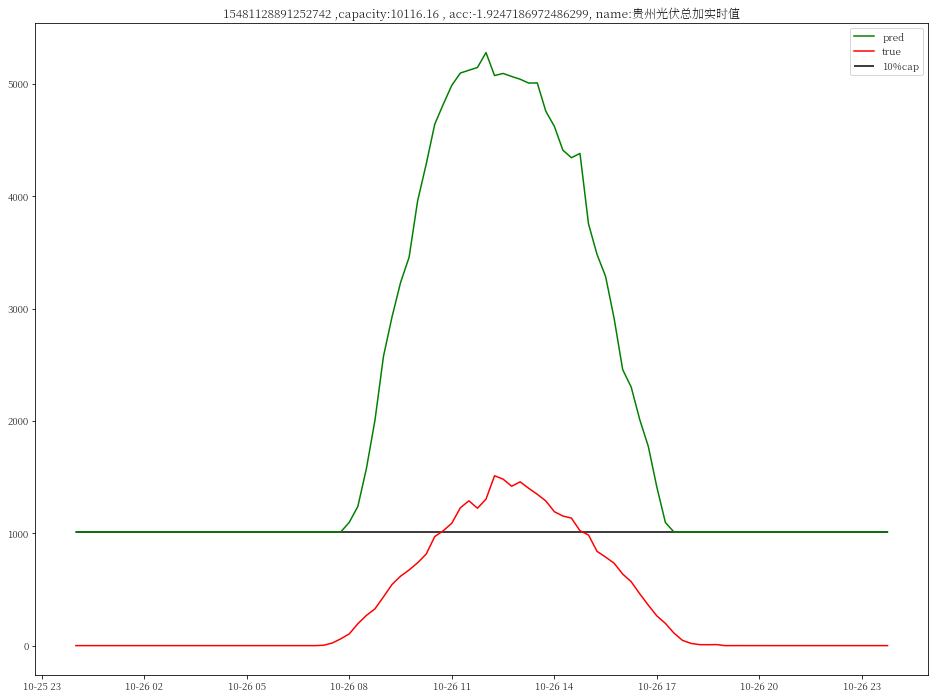

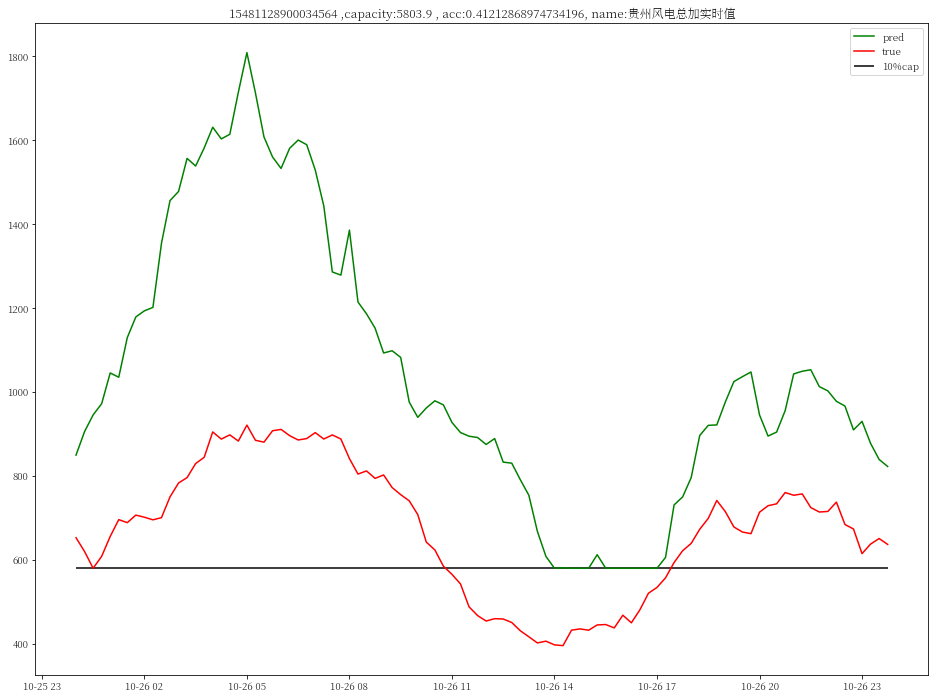

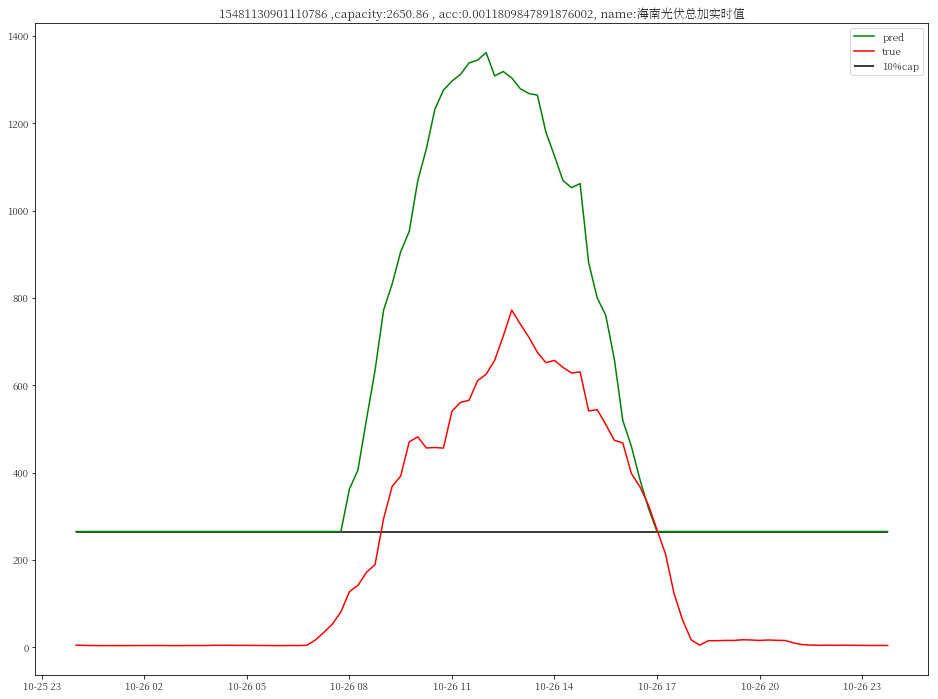

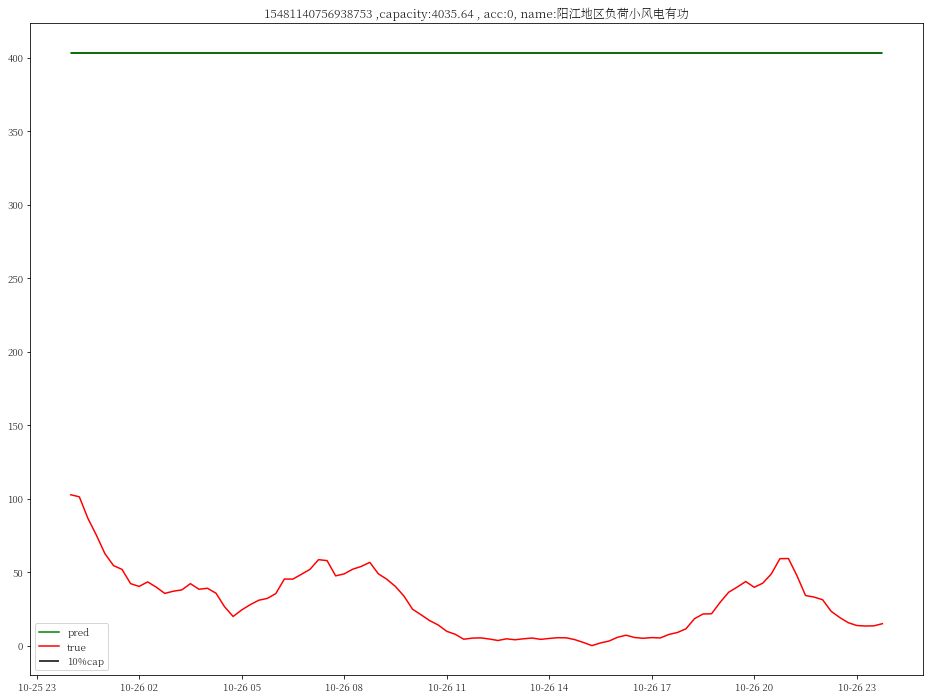

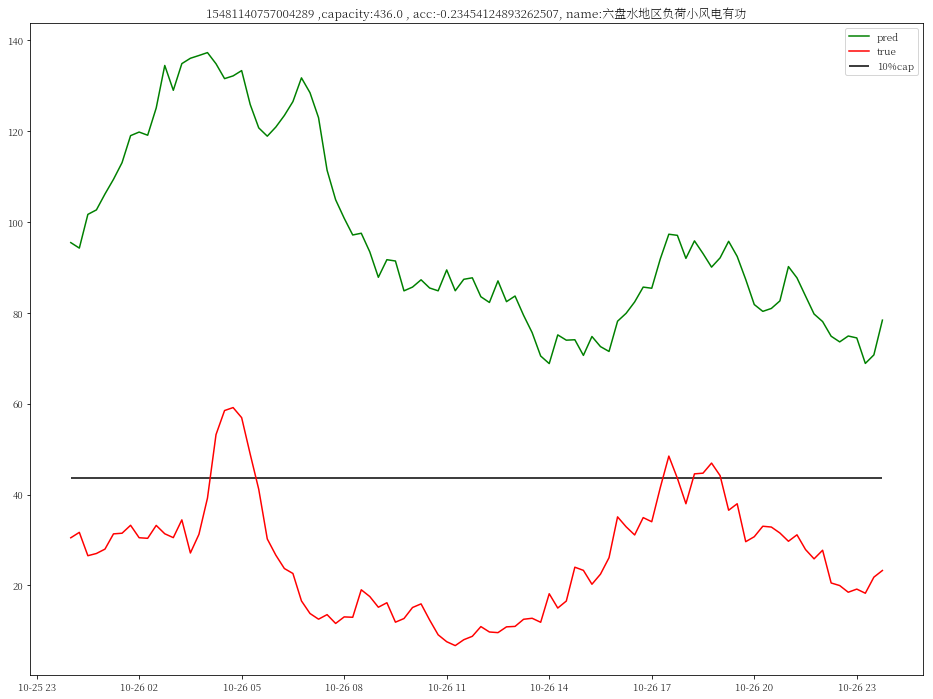

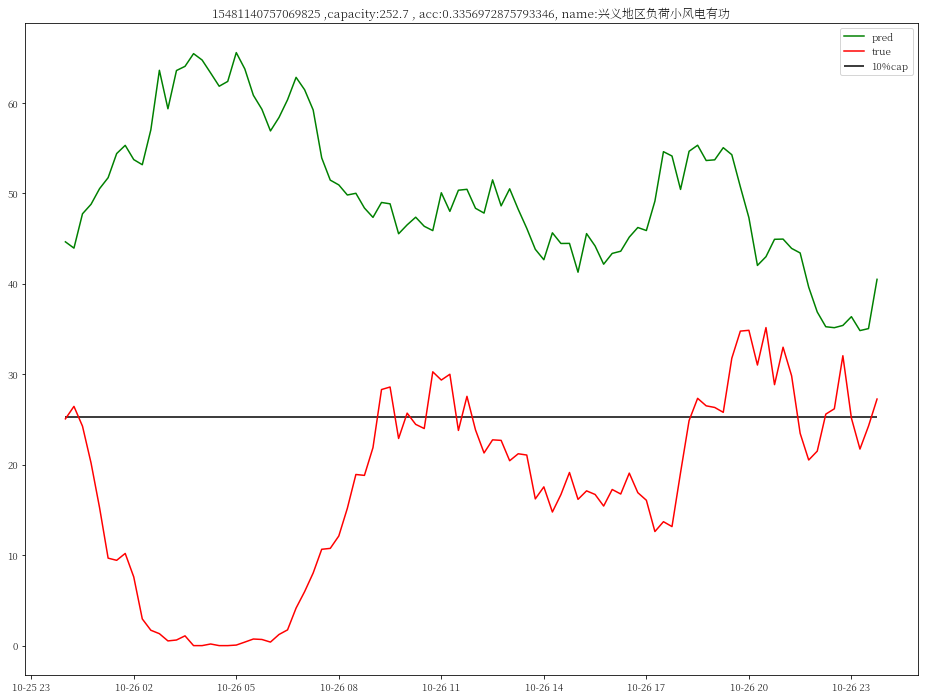

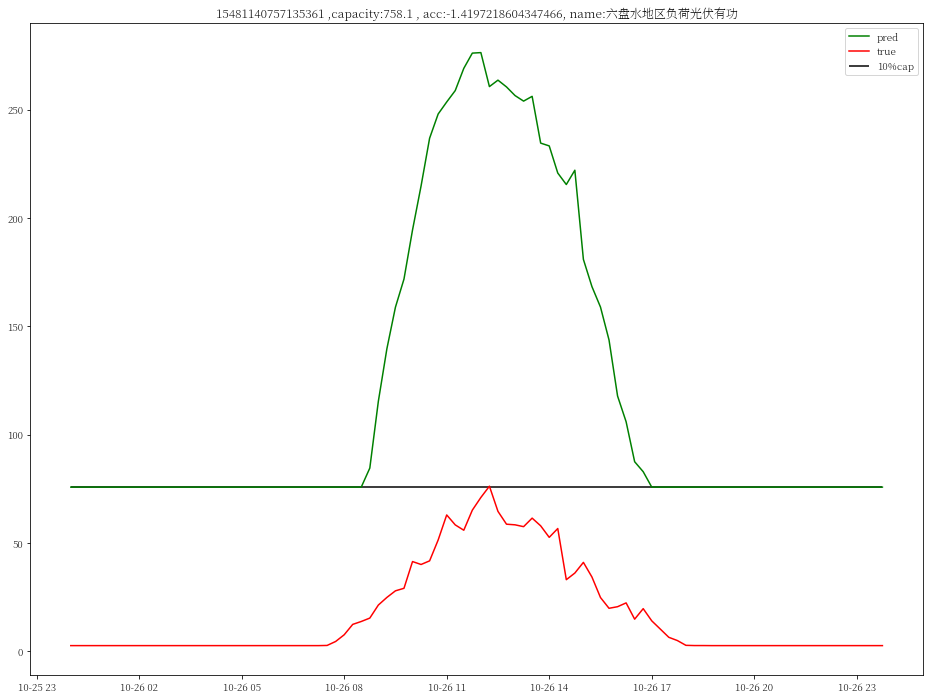

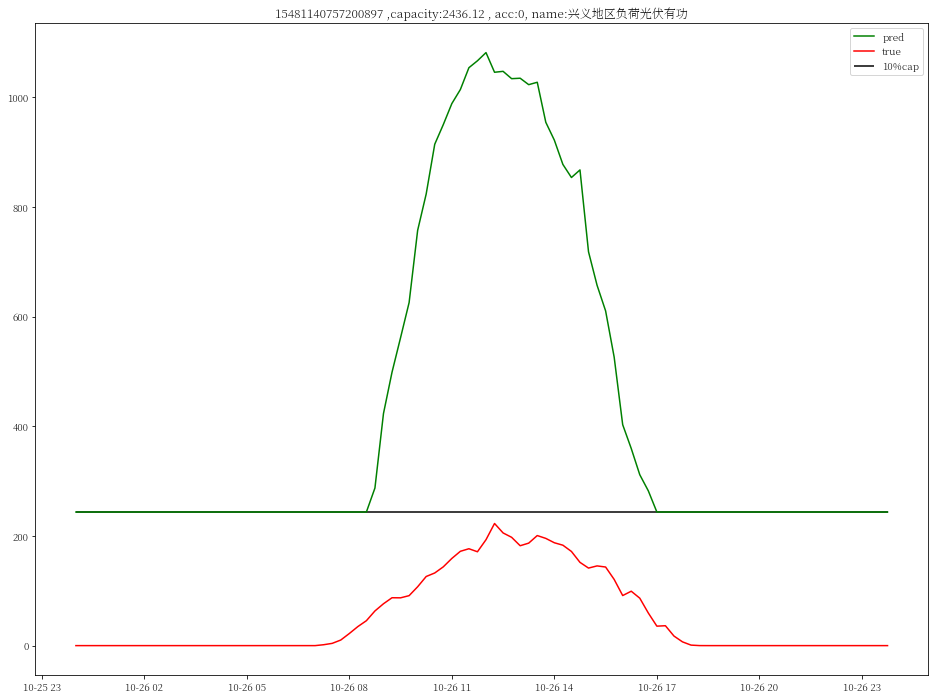

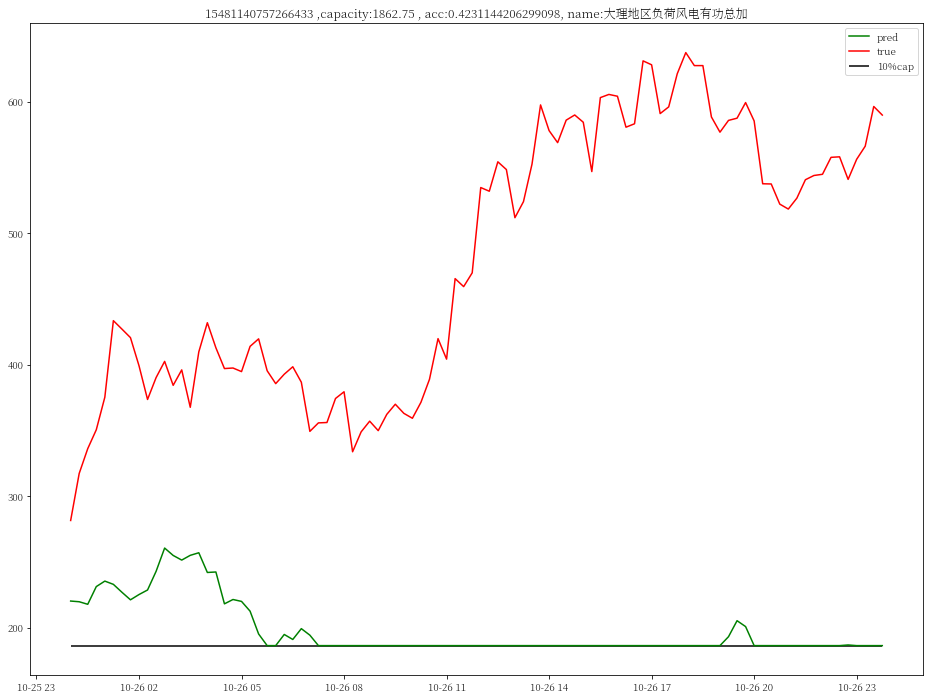

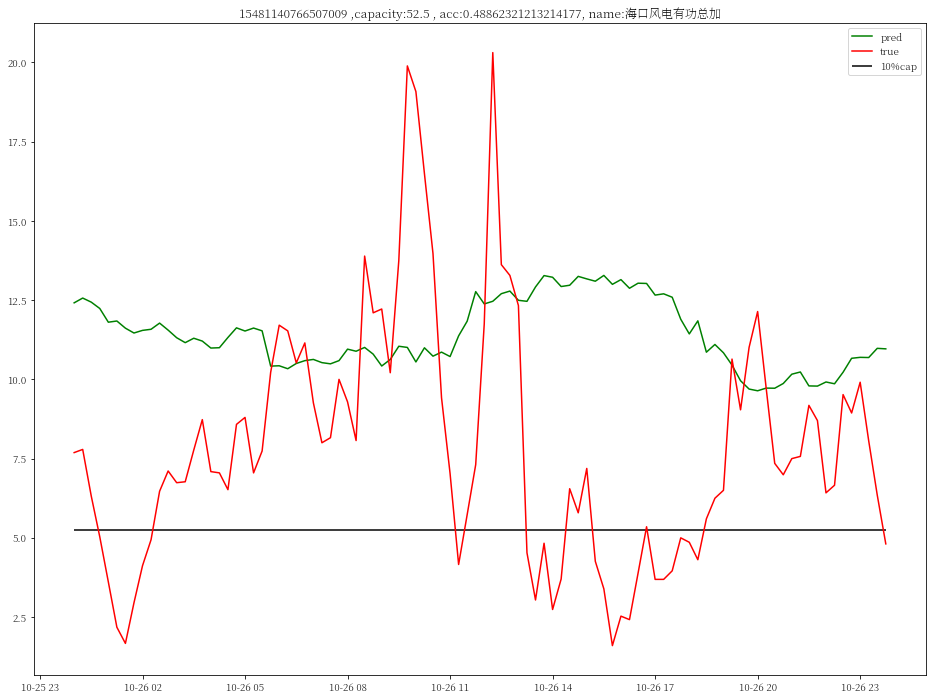

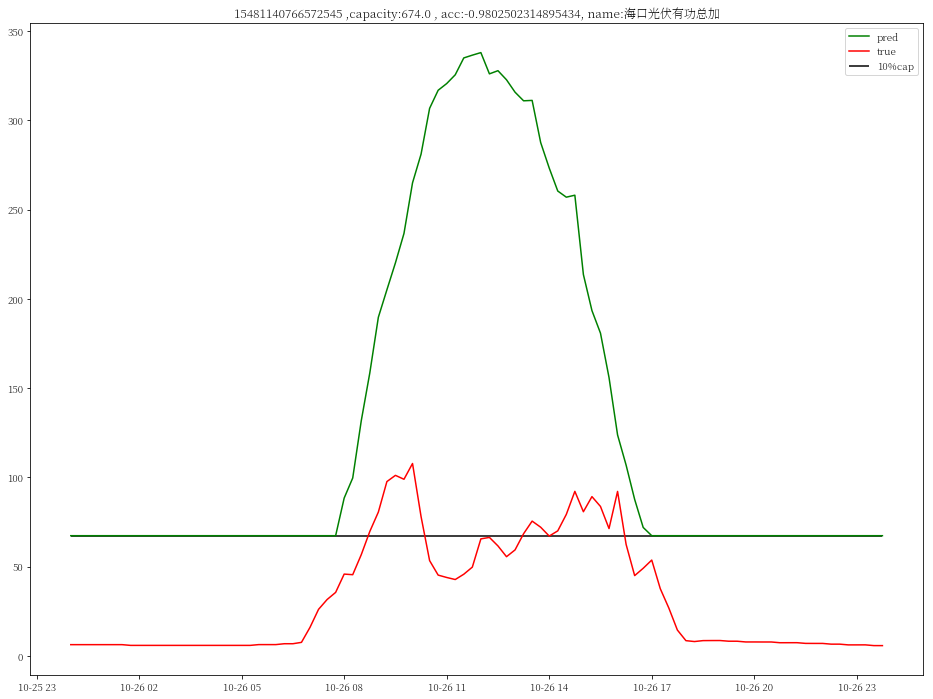

In [101]:
df_pred = pd.read_pickle('results_v1/2023-10-26/df_pred_norm.p')
# dis_bad_oid(df_pred, acc_file='analyzise/acc_ct.csv', display=False)
dis_bad_oid(df_pred, display=True)

In [59]:
df_pred = pd.read_pickle('test_his/new1/2023-10-05/df_pred_2023-10-24 14:40:28.879864.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc_new1.csv', display=False)

2023-10-05 的准确率为
15481130821025794 0.7171534577139742
15481130821156866 0.6131090507744303
15481140766441473 0.8379481223229459
15481140766375937 0
15481140757135361 0
15481140757004289 0.46389679647271087
15481140757200897 0.5578180615463931
15481140757069825 0.5680039953052252
15481140766179329 0.6505671871834973
15481140766113793 0.445086439691164
15481137326915585 0.7077294773035162
15481140757266433 0.4884617653494572
15481130500882435 0.7884731057223229
15481130476634115 0.6642184806747887
15481125255184390 0.6542308428311201
15481129194225670 0.5326791863318829
15481140757790721 0.7513348075551664
15481140757725185 0.41570434192340167
15481130901110786 0.8172523891570813
15481131802034178 0
15481140766572545 0.7850476431583122
15481140766507009 0
15481140756873217 0.853725135937802
15481140830863361 0
15481128891252742 0.28646835413776983
15481128900034564 0.530558923740323
15481140766310401 0.7244556111819707
15481140766244865 0.2937006583977936
15481140756807681 0.758133675424

0.596230300393486

In [51]:
df_pred_power = pd.read_pickle('test_his/fusion/df_radi_wind_power.p')
# df_pred_power = df_pred_power.rename(columns={'power':'y_pred'})
print(df_pred_power)
for date in pd.date_range('2023-10-16', '2023-10-23', freq='D'):
    df_pred = df_pred_power.loc[f'{date} 00:00:00+08:00':f'{date} 23:45:00+08:00']
    dis_bad_oid(df_pred, acc_file='analyzise/acc_fusion.csv', display=False)

                                         oid type       y_pred
power_time                                                    
2023-10-16 00:00:00+08:00  15481140766244865    4   501.690002
2023-10-16 00:00:00+08:00  15481140766375937    4    56.921715
2023-10-16 00:00:00+08:00  15481129194225670    4  3967.586670
2023-10-16 00:00:00+08:00  15481140757725185    4   261.095337
2023-10-16 00:00:00+08:00  15481128891252742    5    -9.003330
2023-10-16 00:00:00+08:00  15481130821025794    5   -18.783243
2023-10-16 00:00:00+08:00  15481125255184390    5   -12.995204
2023-10-16 00:00:00+08:00  15481140830863361    4   594.908936
2023-10-16 00:00:00+08:00  15481140766507009    4    37.227169
2023-10-16 00:00:00+08:00  15481131802034178    4    97.651756
2023-10-16 00:00:00+08:00  15481140766572545    5    -1.525007
2023-10-16 00:00:00+08:00  15481140757790721    5     5.766822
2023-10-16 00:00:00+08:00  15481140766113793    4   212.060562
2023-10-16 00:00:00+08:00  15481140766179329    5     1

In [120]:
for date in pd.date_range('2023-10-01', '2023-10-26', freq='D'):
    df_pred = pd.read_pickle('test_his/center_jiutian_del/{}/df_pred_v1.p'.format(date.date()))
#     dis_bad_oid(df_pred, acc_file='analyzise/acc_del_v1.csv', display=False)
    dis_bad_oid(df_pred,  display=False)

2023-10-01 的准确率为
15481140757790721 0.8219469874038177
15481130500882435 0.8958420411407035
15481130476634115 0.6334562456154097
15481140756807681 0.8482613590676048
15481140766375937 0.9284064031073717
15481137326915585 0.8202239923112135
15481140766572545 0.727101575101861
15481130821025794 0.8931762662299387
15481130821156866 0.6061204610882607
15481140757135361 0.7427534597461642
15481140766244865 0
15481140756938753 0
15481140757200897 0.7022639408401421
15481129194225670 0.7315219537474349
15481140766507009 0
15481140766441473 0.8207450148192554
15481140830863361 0
15481128900034564 0.707167967439656
15481125255184390 0.7863331136324367
15481140757266433 0.6056245842586512
15481140757069825 0.7081761718151327
15481140766310401 0.8523399515104014
15481140757004289 0.7544959403854212
15481140756873217 0.821541315715207
15481130901110786 0.8046890703892386
15481128891252742 0.7750107464967451
15481140757725185 0.883916575862402
15481140766113793 0.8438939475617749
15481131802034178 0

FileNotFoundError: [Errno 2] No such file or directory: 'test_his/center_jiutian_del/2023-10-18/df_pred_v1.p'

In [55]:
for date in pd.date_range('2023-10-24', '2023-10-24', freq='D'):
    df_pred1 = pd.read_pickle('results_v1/{}/df_pred_norm.p'.format(date.date()))
    df_pred2 = pd.read_pickle('results_v1/{}/df_pred_ct.p'.format(date.date()))
    df_pred = df_pred2.copy()
    df_pred['y_pred'] = (df_pred1['y_pred'] + df_pred2['y_pred'])/2
#     df_pred['y_pred'] = (df_pred1['y_pred'] + 2*df_pred2['y_pred'])/3
    dis_bad_oid(df_pred, acc_file='analyzise/accnorm.csv', display=False)

2023-10-24 的准确率为
15481130821025794 0.43724665115499894
15481130821156866 0.5979671337028938
15481140766441473 0.31863425801653744
15481140766375937 0.5345436829851652
15481140757135361 0.24776452574422902
15481140757004289 0.7680965262781567
15481140757200897 0.4252648941668187
15481140757069825 0.029248886969670096
15481140766179329 0.8431510564751292
15481140766113793 0
15481137326915585 0
15481140757266433 0.682813632014977
15481130500882435 0.6921533364910659
15481130476634115 0.700913071434067
15481125255184390 0.8338400664481123
15481129194225670 0.3463778362404675
15481140757790721 0
15481140757725185 0.31646272439442025
15481130901110786 0.11485641779250466
15481131802034178 0.6457744142026356
15481140766572545 0.6582178643303211
15481140766507009 0.5225513113888358
15481140756873217 0.7455763352344653
15481140830863361 0.5936219368290593
15481128891252742 0.6073961029989738
15481128900034564 0.7245669693656451
15481140766310401 0.6372114602374226
15481140766244865 0.5286211030

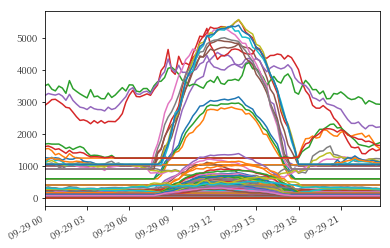

In [27]:
for oid, val in df_pred1.groupby('oid'):
    val['y_pred'].plot()
    df_pred2.loc[df_pred2['oid']==oid, 'y_pred'].plot()
    df_pred.loc[df_pred['oid']==oid, 'y_pred'].plot()

In [ ]:
df_pred2

In [ ]:
df_radi_align = pd.read_pickle('data/center_jiutian/2023-08-02-radi.p')
df_radi_align

In [13]:
df_radi_align = pd.read_pickle('test_his/center_jiutian/2023-09-01/df_radi_align.p')

In [ ]:
df_radi_align

In [ ]:
glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')
# df_t = pd.read_pickle(glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')[-1])
print(glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')[-1])

In [9]:
import glob
acc_rate_ret_ls = []
for date in pd.date_range('2023-09-01', '2023-10-02', freq='D'):
    for file in glob.glob('test_his/center_jiutian_del/{}/df_pred.p'.format(date.date())):
        df_pred = pd.read_pickle(file)
#         print(file[-1])
        acc_rate_ret = dis_bad_oid(df_pred, acc_file='analyzise/acc_ct_del.csv')
        print(acc_rate_ret)
        acc_rate_ret_ls.append(acc_rate_ret)


2023-09-01 的准确率为
15481130821025794 0.6432103718819154
15481130821156866 0.5052489341821211
15481140766441473 0.7940389849285918
15481140766375937 0.515753548857538
15481140757135361 0.7241189157696769
15481140757004289 0.5485240369535407
15481140757200897 0.7699336811586047
15481140757069825 0.6222146068961273
15481140766179329 0.762790608332616
15481140766113793 0.6515986690411484
15481137326915585 0.5711769117788545
15481140757266433 0.6643578182183467
15481130500882435 0.546488638471577
15481130476634115 0.5626714093880345
15481125255184390 0.8114803486634709
15481129194225670 0.5646311202396794
15481140757790721 0
15481140757725185 0.6833813152206254
15481130901110786 0.8736980867109487
15481131802034178 0.6076925368835787
15481140766572545 0.8040478656752585
15481140766507009 0.6003805840878208
15481140756873217 0.8323689968955355
15481140830863361 0.8163172751511867
15481128891252742 0.8272930328421538
15481128900034564 0.681592022830266
15481140766310401 0.7607792189484072
15481

In [ ]:
import glob
acc_rate_ret_ls = []
for date in pd.date_range('2023-09-19', '2023-09-26', freq='D'):
    for file1, file2 in zip(glob.glob(('results_v1/{}/df_pred.p'.format(date.date()))), glob.glob(('test_his/center_jiutian/{}/df_pred.p'.format(date.date())))):
        print(file1, file2)
        df_pred1 = pd.read_pickle(file1)
        df_pred2 = pd.read_pickle(file2)
        df_pred = df_pred1.copy()
        df_pred['y_pred'] = (df_pred1['y_pred'] + df_pred2['y_pred'])/2
        acc_rate_ret = dis_bad_oid(df_pred, acc_file='analyzise/acc_NORM_ct_fusion.csv')
        print(acc_rate_ret)
        acc_rate_ret_ls.append(acc_rate_ret)

In [112]:
df_radi = pd.read_pickle('data/center_jiutian/2023-10-07-radi.p')
df_cp = pd.read_pickle('data/center_jiutian/center_points.p')

In [131]:
df_oid = pd.read_pickle('data/oid/newest.p')

In [ ]:
df_oid

In [ ]:
df_rd_ct.mean()

In [113]:
df_cp.loc[df_cp.oid == '15481130821025794'].values

array([[99.60050663, 23.68235734, 1128.0, '15481130821025794', 163],
       [100.16904907, 25.81133219, 2638.92, '15481130821025794', 163],
       [100.84604967, 25.20002341, 3479.75, '15481130821025794', 163],
       [103.25839722, 24.24956313, 1857.5, '15481130821025794', 163],
       [102.79059829, 26.16275098, 1829.35, '15481130821025794', 163]],
      dtype=object)

In [114]:
df_cp.loc[df_cp.oid == '15481130821025794', 'jd'].values

array([ 99.60050663, 100.16904907, 100.84604967, 103.25839722,
       102.79059829])

In [118]:
(df_radi.jd == 99.60050663).sum()

96

In [138]:
df_radi_ls = []
for date in pd.date_range('2023-09-01', '2023-10-07', freq='D'):
    df_radi_ls.append(pd.read_pickle('data/center_jiutian/{}-radi.p'.format(date.date())))
df_radi = pd.concat(df_radi_ls)
df_radi_ls_ = []
for jd, wd in zip(df_cp.loc[df_cp.oid == '15481140757135361', 'jd'].values, df_cp.loc[df_cp.oid == '15481140757135361', 'wd'].values):
    df_tmp = df_radi.loc[(df_radi.jd==jd) & (df_radi.wd==wd)]
    df_radi_ls_.append(df_tmp)

In [ ]:
for df_ in df_radi_ls_:
    print(df_.jd.values[0], df_.wd.values[0])
    plt.figure(figsize=(24, 8))
    plt.plot(df_.total_radiation)

In [ ]:
df_pred = pd.read_pickle('results_v1/2023-09-24/df_pred.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc.csv')

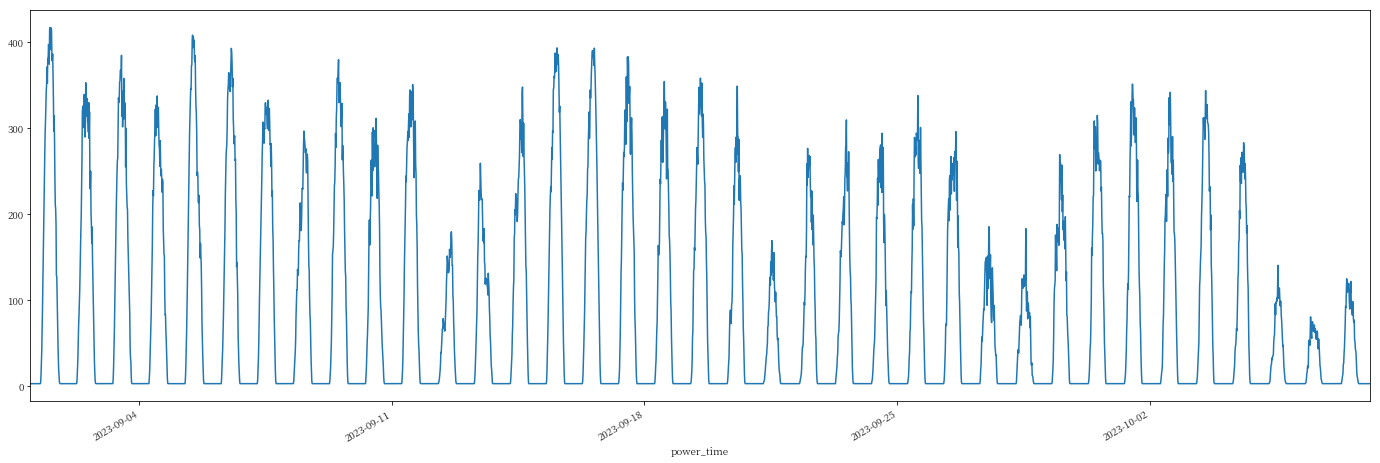

In [140]:
df_power = pd.read_pickle('results_v1/2023-10-09/df_power.p')
df_power = df_power.loc[df_power['oid'] == '15481140757135361', :]
df_power['power'] = df_power['power'].astype(float)
df_power.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

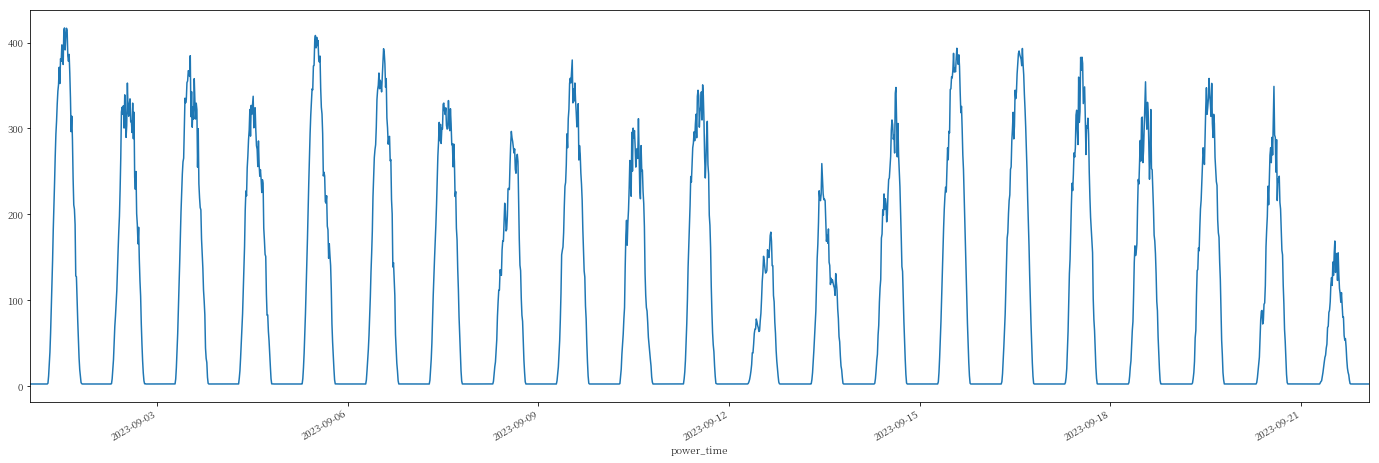

In [25]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481140757135361', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

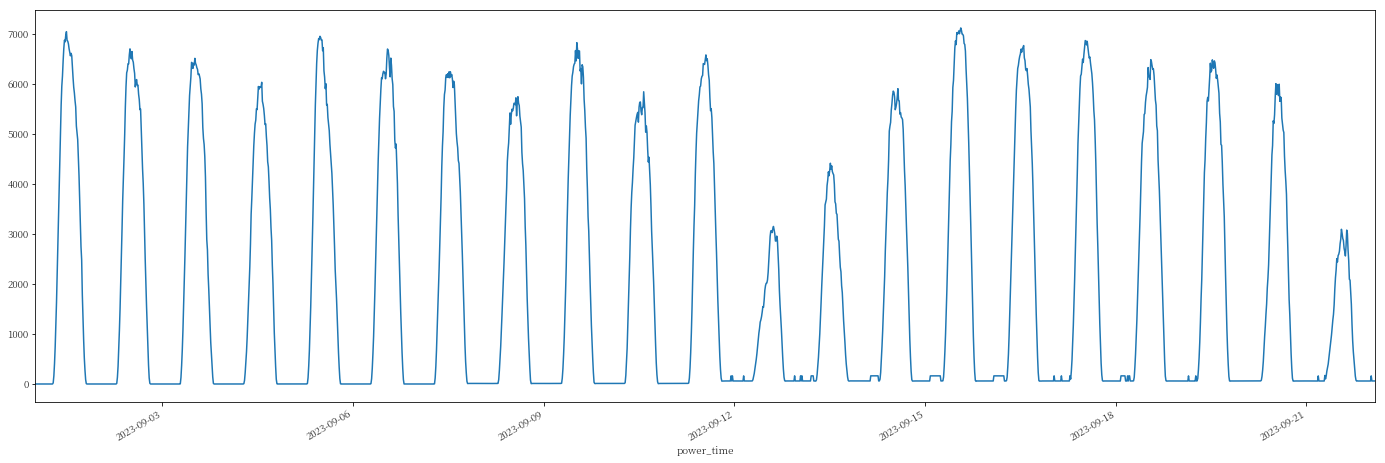

In [23]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481128891252742', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

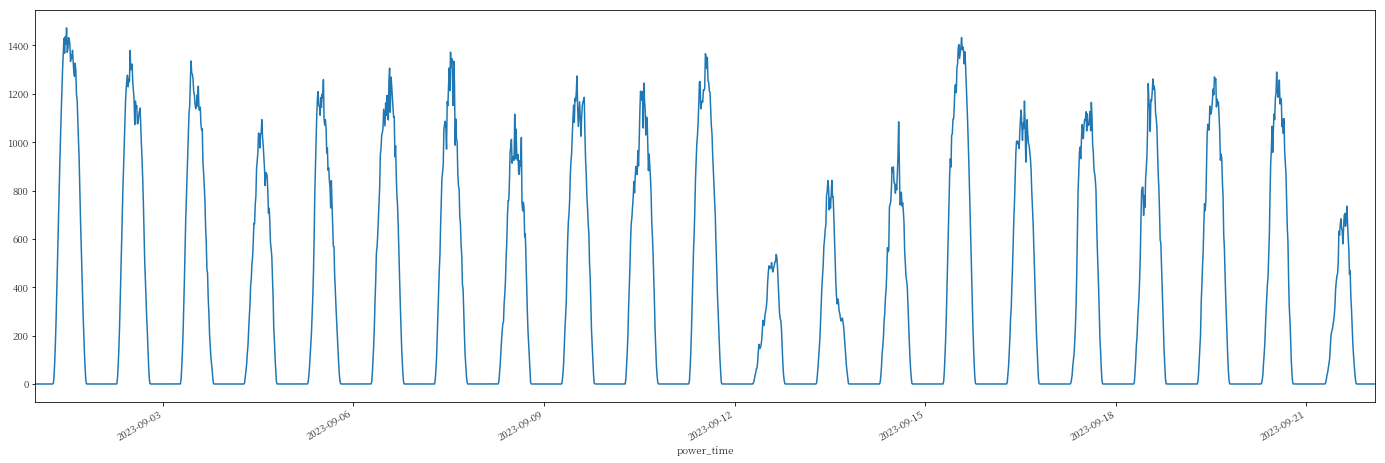

In [24]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481140757200897', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

### 测试保底的代码

In [28]:
def test_baseline(date_):
    df_all = pd.read_pickle('results_v1/2023-09-19/df_power.p')
    prev_date = str((datetime.datetime.strptime(date_, '%Y-%m-%d') - datetime.timedelta(days=2)).date())
    df_prev = df_all.loc[prev_date:prev_date, ['oid', 'power']]
    df_post = df_all.loc[date_:date_, ['oid', 'power']]
    
    df_prev = df_prev.rename({'power' : 'y_pred'}, axis=1)
    df_prev.index += datetime.timedelta(days=2)
    
    acc_rate_ret = dis_bad_oid(df_prev, acc_file='analyzise/acc_baseline.csv')
    return acc_rate_ret

2023-09-16 的准确率为
15481125255184390 0.5374379246069034
15481128891252742 0.8565287216555695
15481128900034564 0.6840704556985358
15481129194225670 -2.622800180029203
15481130476634115 0.4814314362546388
15481130500882435 0.7383053643754363
15481130821025794 0.9174536522671322
15481130821156866 0.9418869566450803
15481130901110786 0.29344890898816534
15481131802034178 0.2671316384549862
15481137326915585 0.868759437199881
15481140756807681 0.6561584401206327
15481140756873217 0.20917844610883862
15481140756938753 0.4312346520874315
15481140757004289 0.3966243375683721
15481140757069825 0.32852963981779737
15481140757135361 0.7717831018305228
15481140757200897 0.7484191241834126
15481140757725185 0.2050012698966317
15481140757790721 0.8618672450032931
15481140766113793 -2.858573974364119
15481140766179329 0.5435232724120855
15481140766244865 -2.2865099609574027
15481140766310401 0.757633928225096
15481140766375937 0.19924387276281397
15481140766441473 -0.335355938414059
15481140766507009 

0.44885102506983293

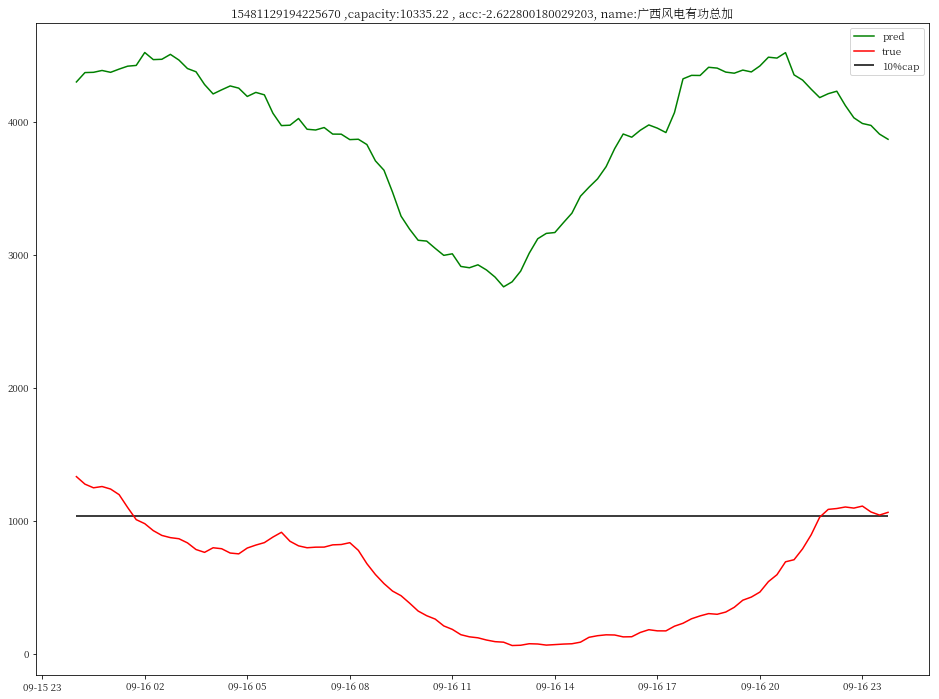

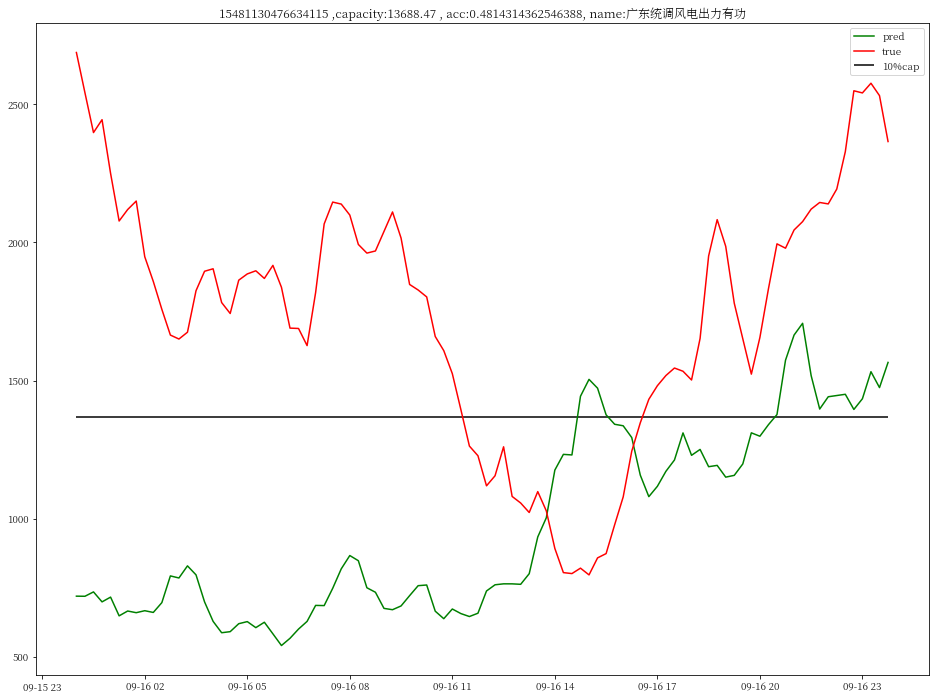

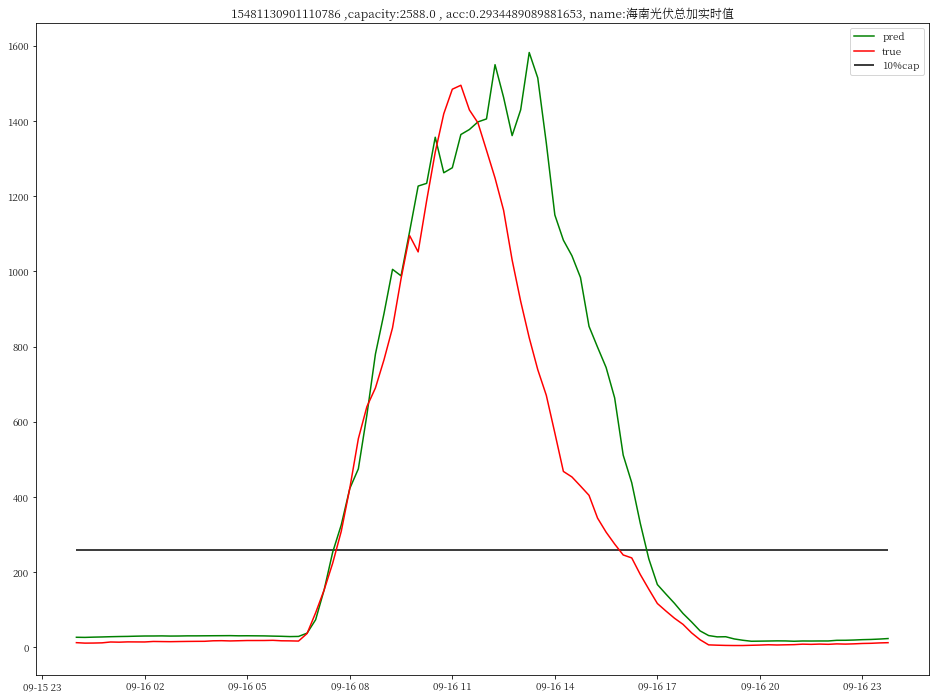

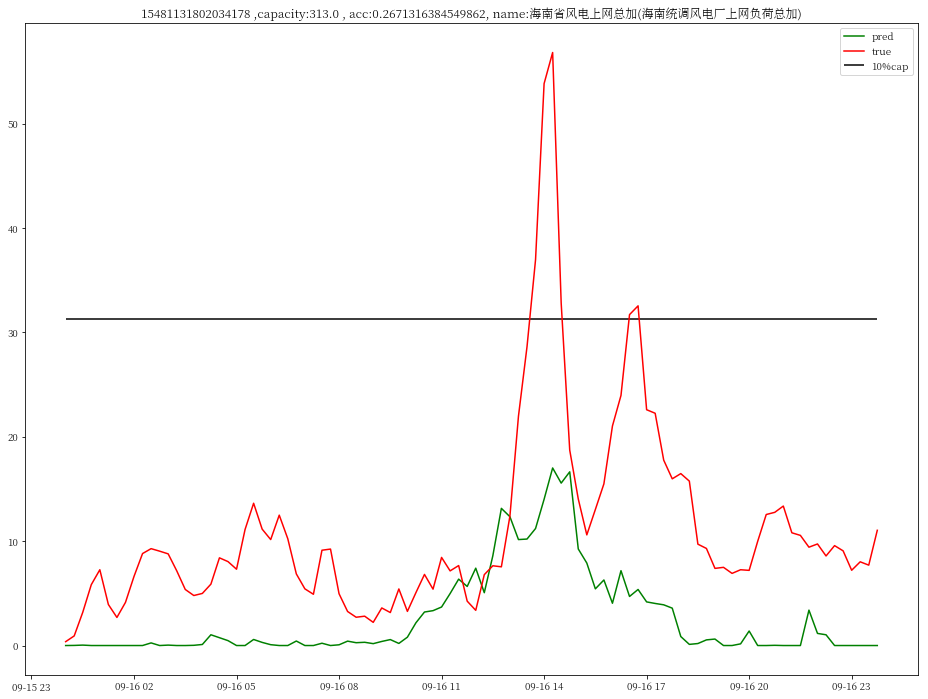

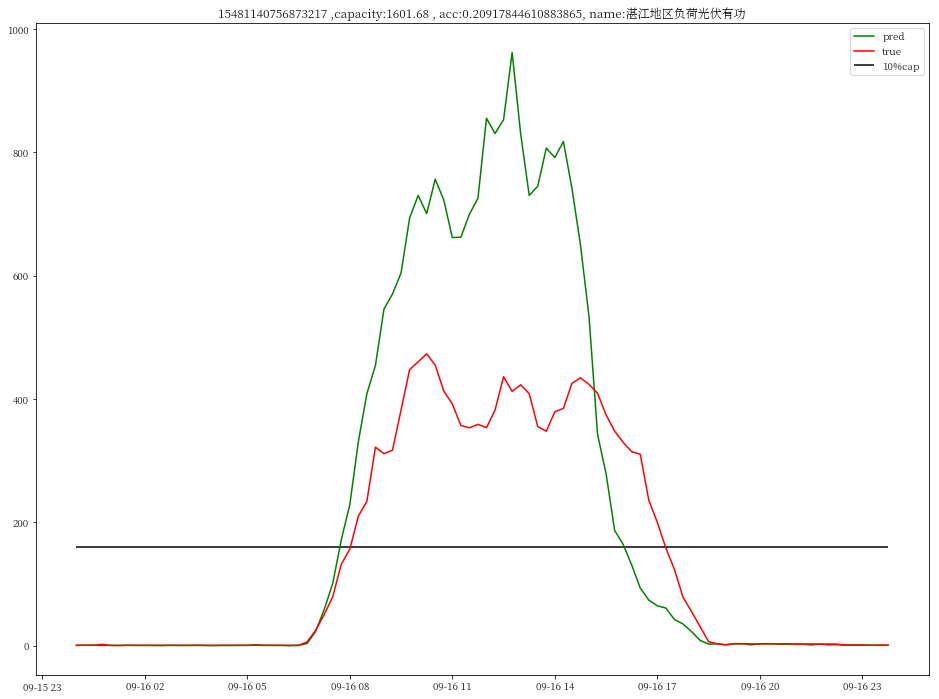

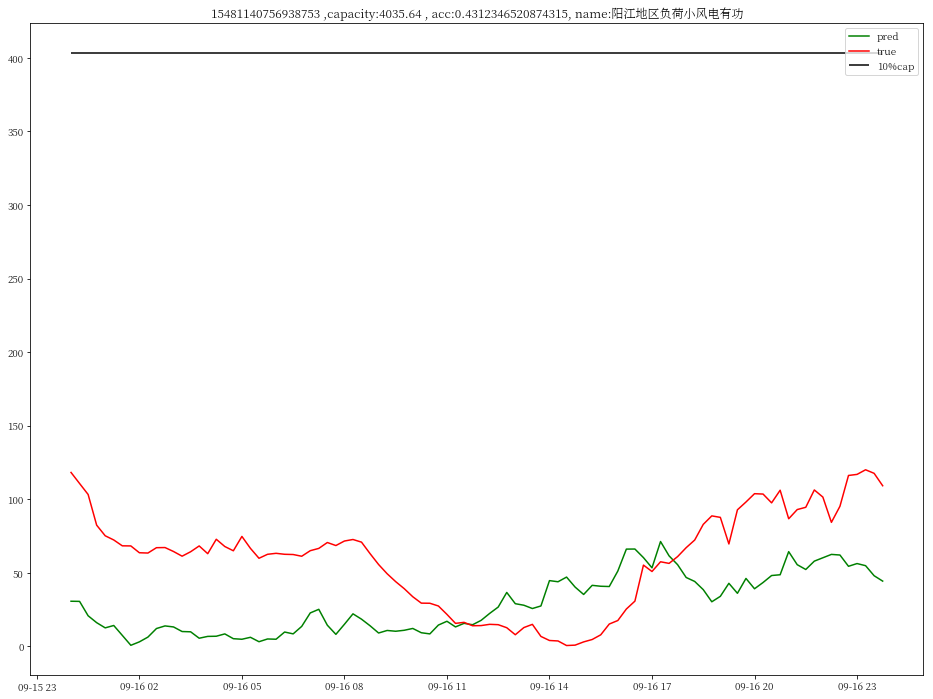

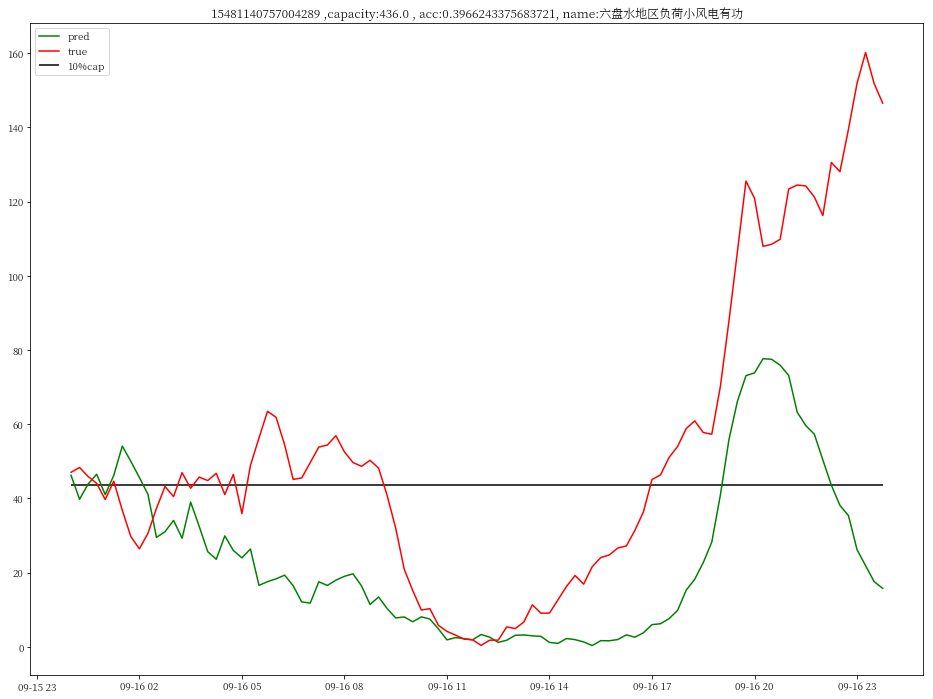

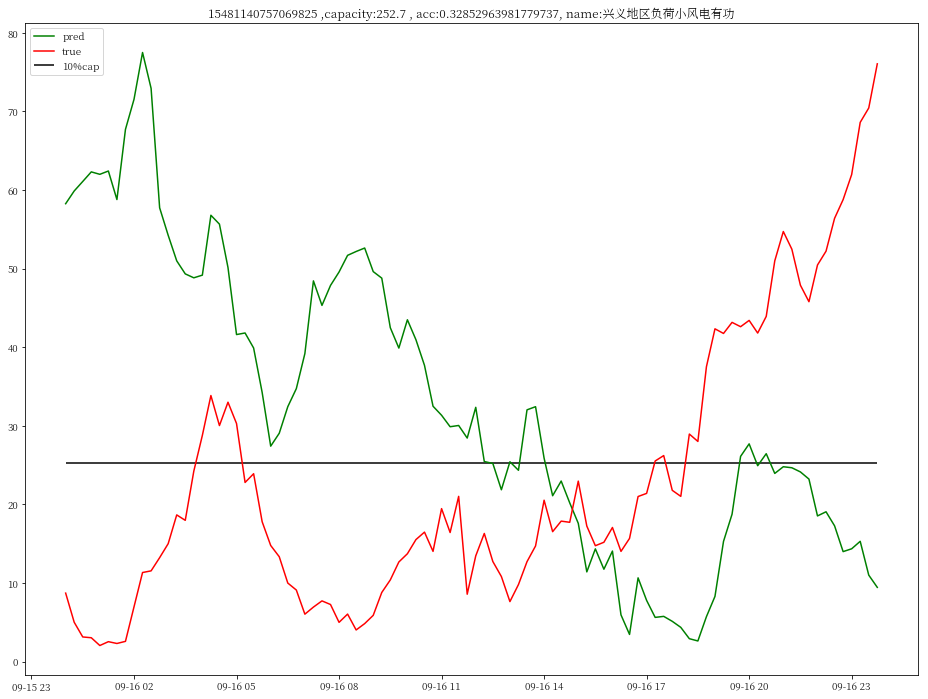

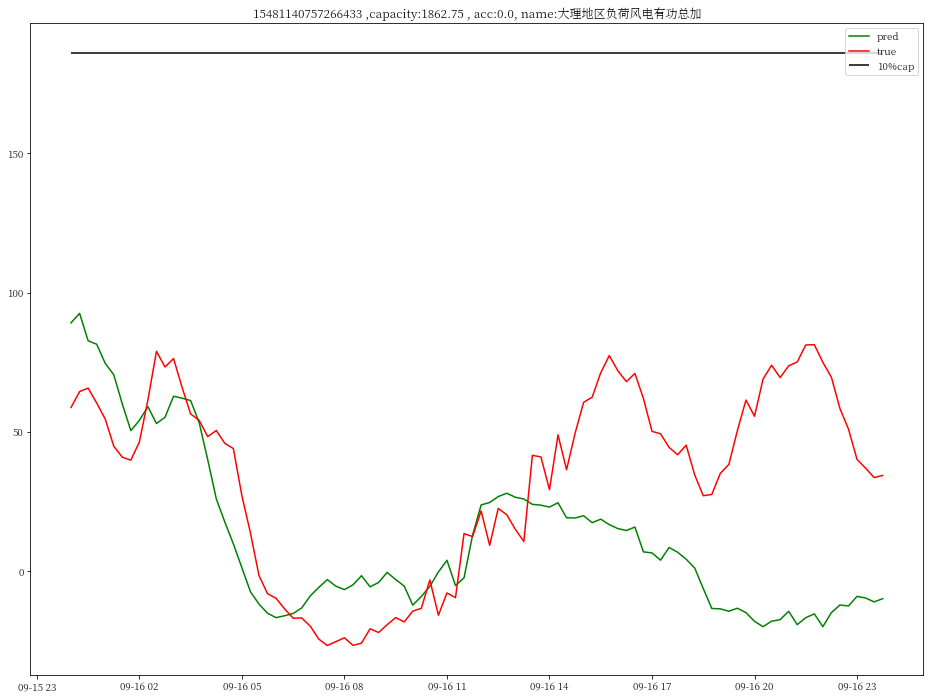

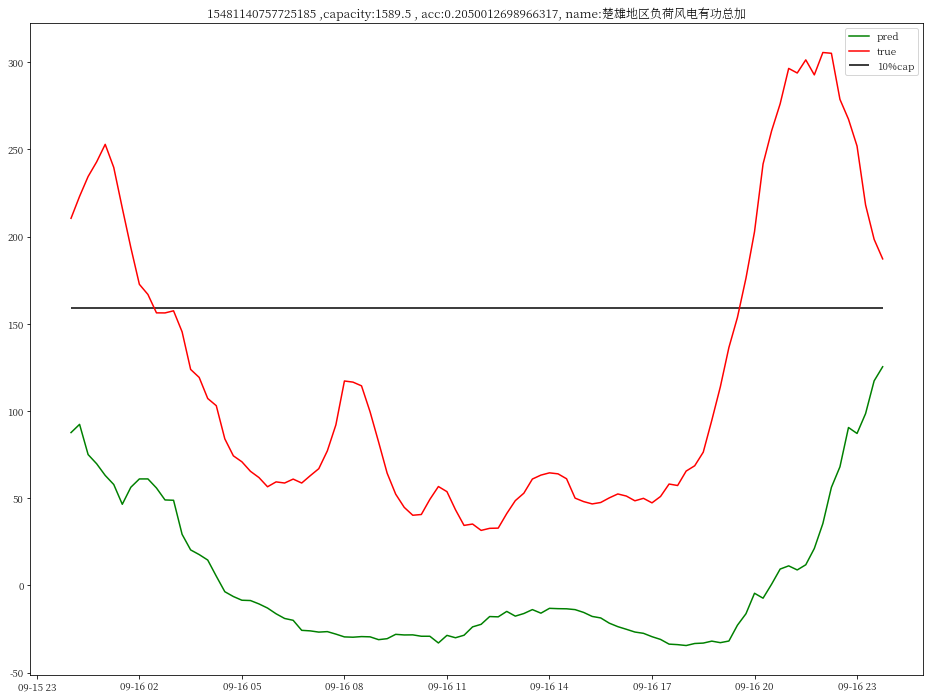

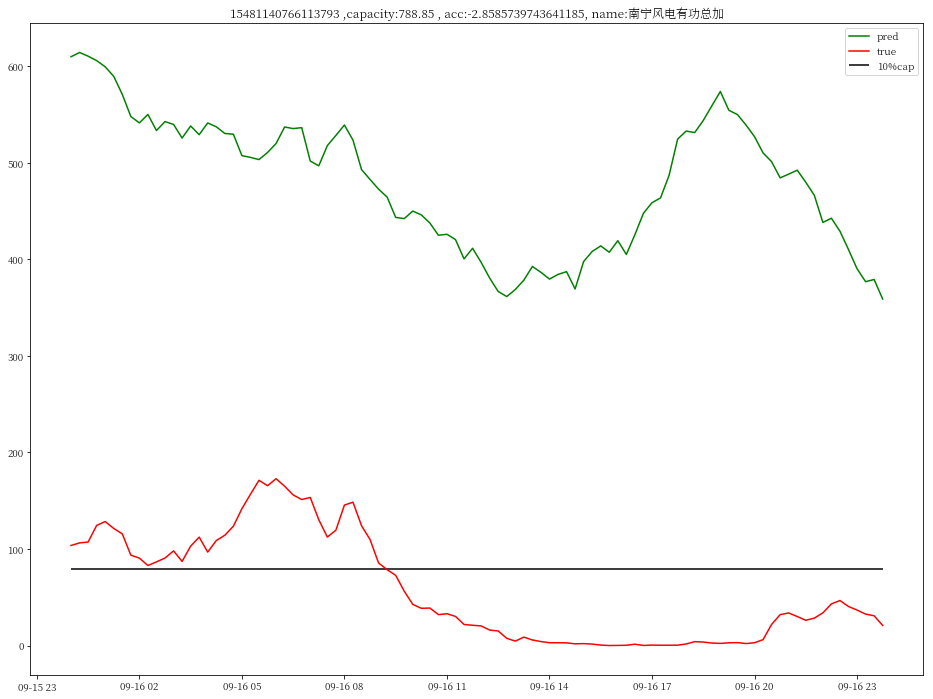

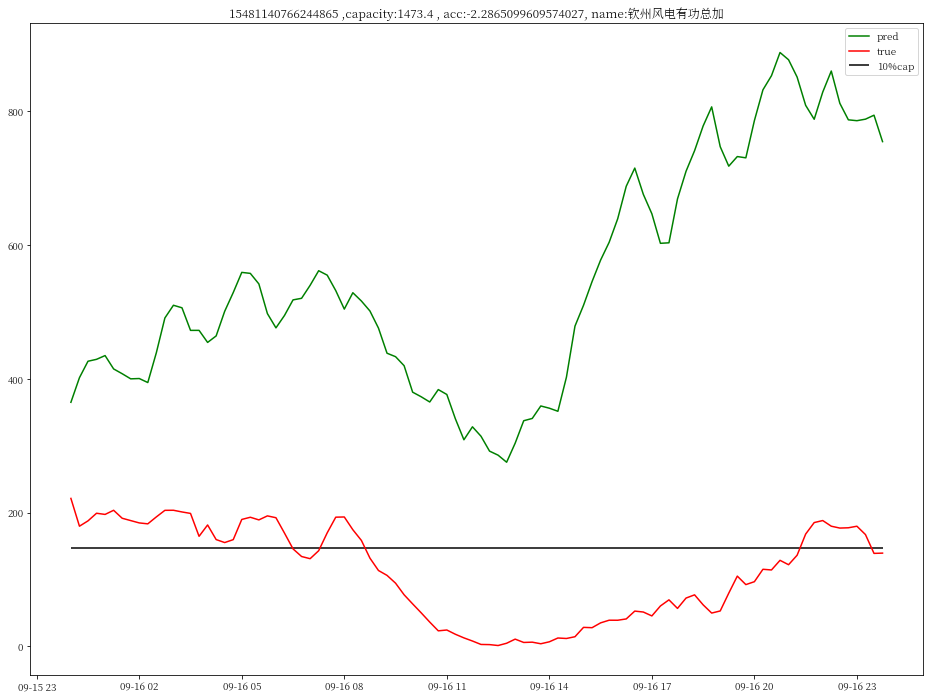

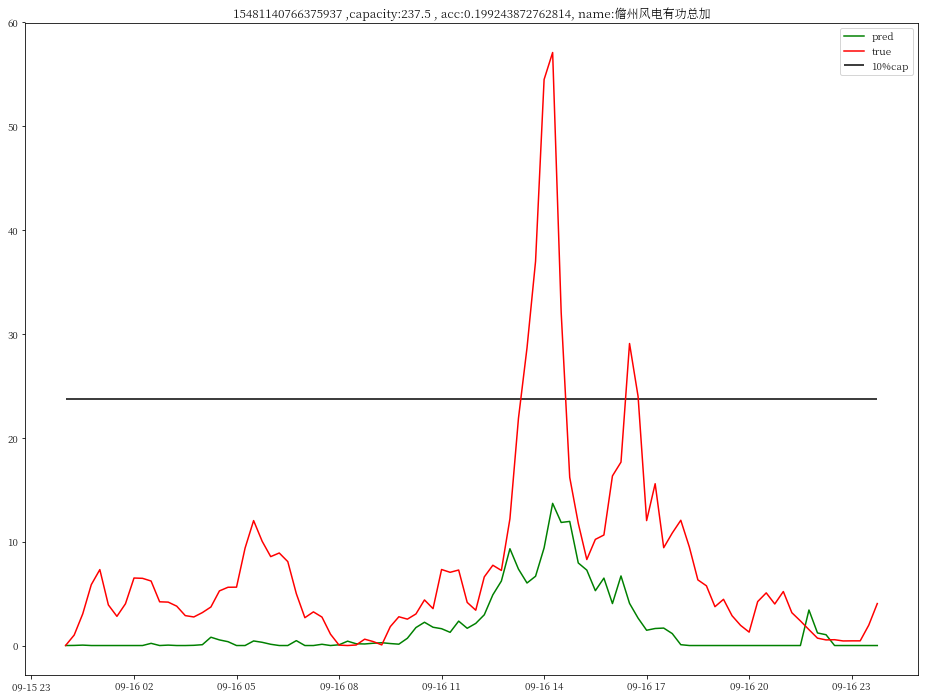

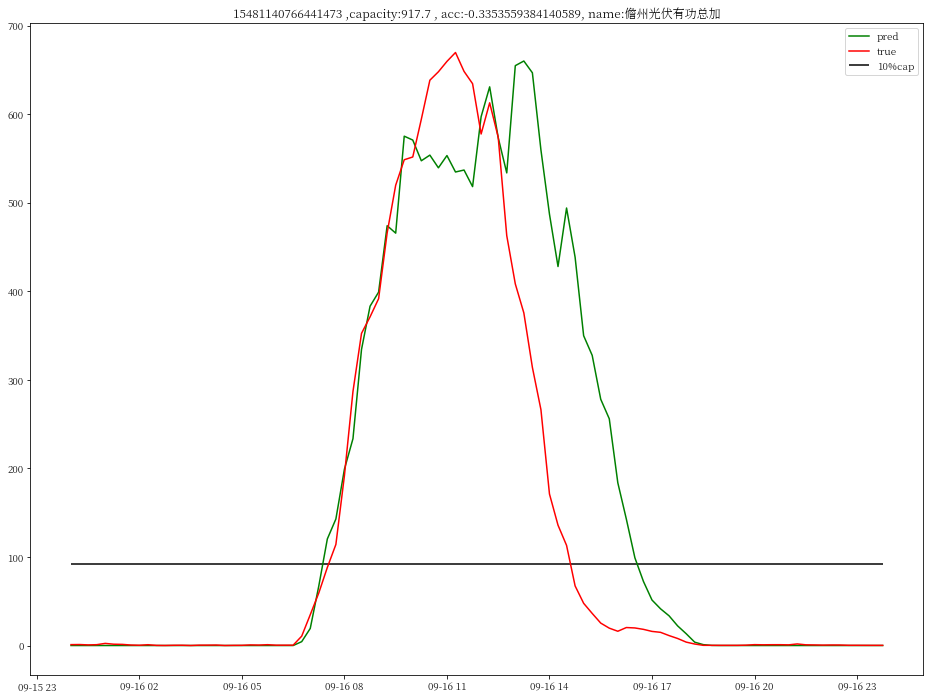

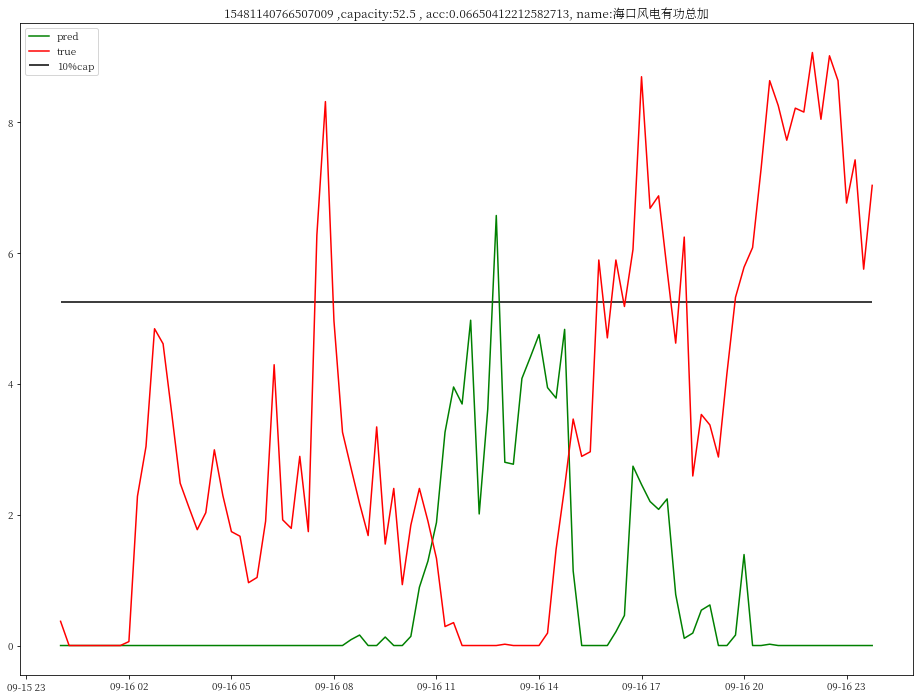

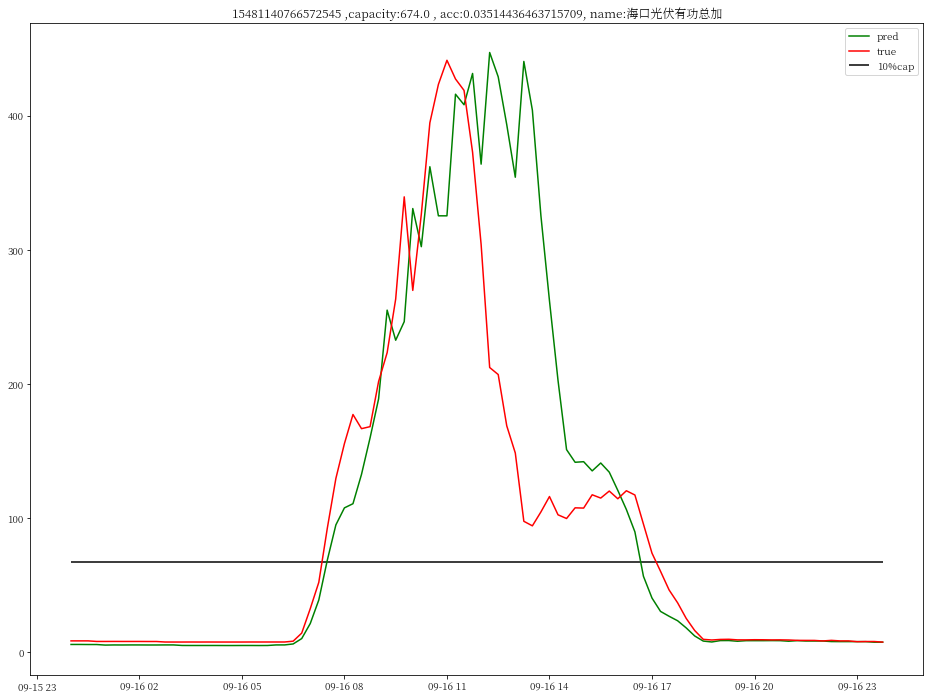

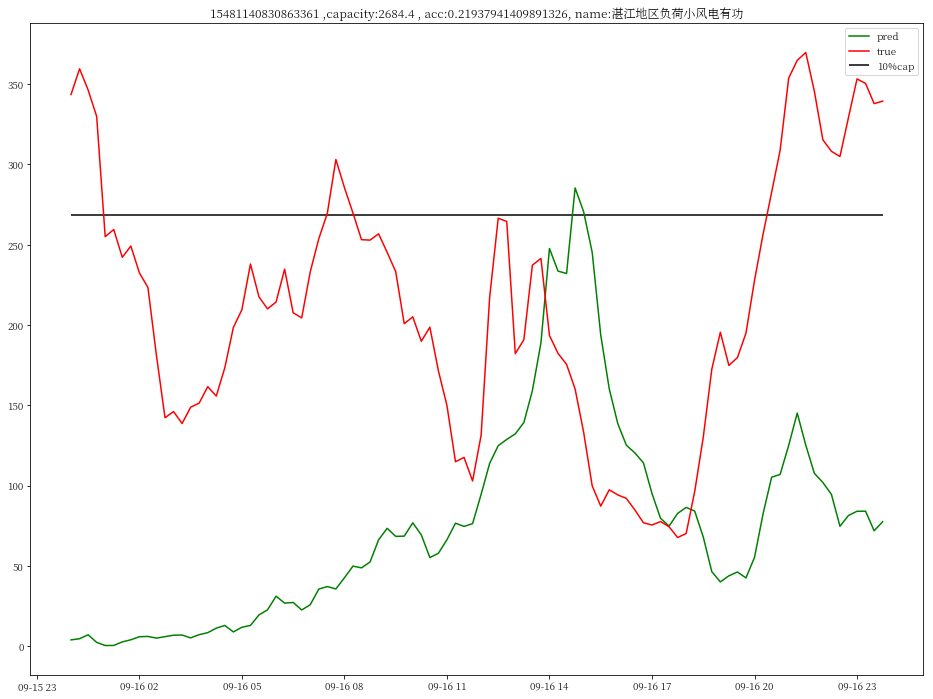

In [31]:
test_baseline('2023-09-16')

In [ ]:
import catboost as cb
model = cb.CatBoostRegressor()
model.load_model('test_his/center_jiutian_del/2023-10-04/15481140757135361')
feau_impo = model.get_feature_importance()
feau_name = model.feature_names_
df = pd.DataFrame({'name':feau_name, 'impo':feau_impo})
df.sort_values('impo', ascending=False)

In [53]:
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/2023-09-19/wind.p')

In [91]:
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/2023-09-01/wind.p')

In [95]:
df_power = pd.read_pickle('results_v1/{}/df_power.p'.format('2023-09-01'))

In [31]:
df_qxj = pd.read_pickle('data/qxj_weather/2023-09-18.p')

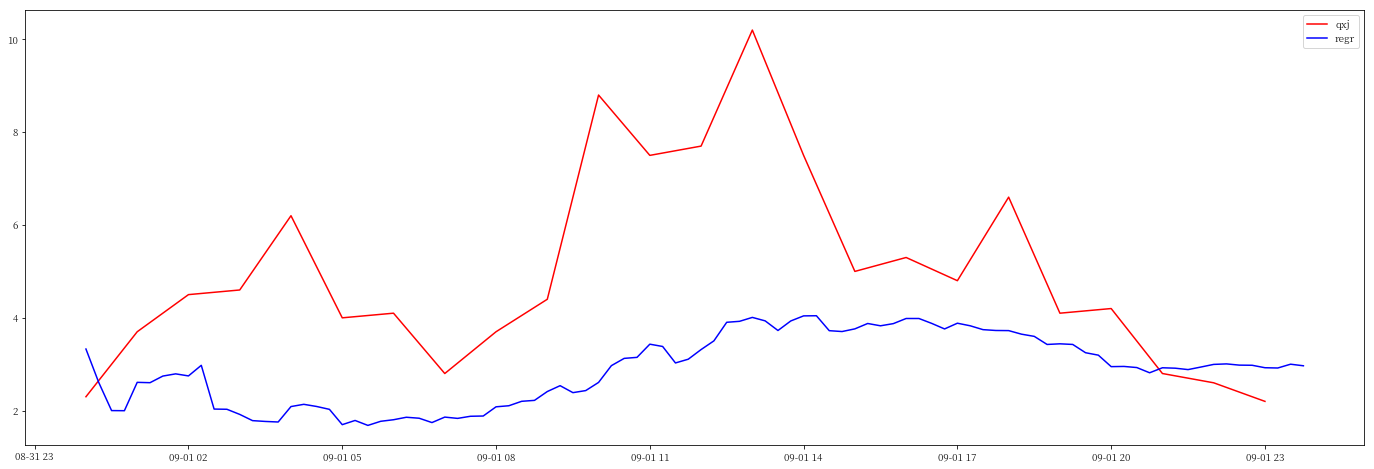

In [90]:
date = '2023-09-01'
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/{}/wind.p'.format(date))
df_qxj = pd.read_pickle('data/qxj_weather/{}.p'.format(date))
loc = 390
plt.figure(figsize=(24,8))
show_qxj = df_qxj[['jd','wd', 'zlsc', 'pjfs2fz']].sort_values(['jd', 'wd', 'zlsc']).iloc[(loc-1)*96:loc*96].replace(9999, np.nan).dropna()
show_qxj['zlsc'].apply(pd.to_datetime)
show_qxj['pjfs2fz'].apply(pd.to_numeric)
show_qxj.set_index('zlsc')
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'pjfs2fz']
plt.plot(show_qxj['zlsc'], show_qxj['pjfs2fz'], color='r', label='qxj')
plt.plot(show_jiutian2qxj[(loc-1)*96:loc*96], color='b', label='regr')
plt.legend()

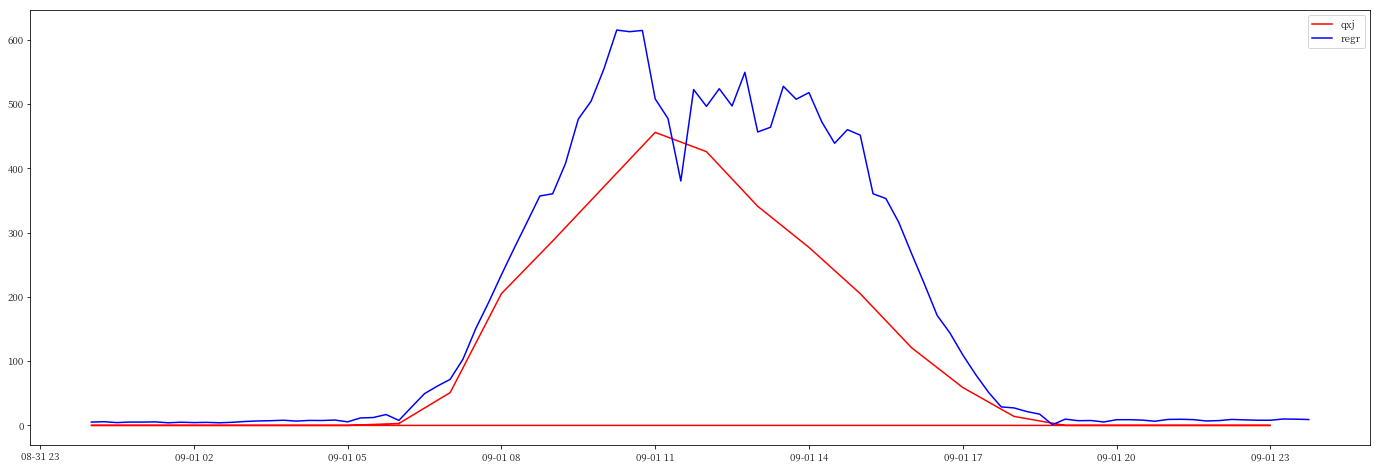

In [77]:
date = '2023-09-01'
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/{}/radi.p'.format(date))
df_qxj = pd.read_pickle('data/qxj_radiation/{}.p'.format(date))
loc = 15
plt.figure(figsize=(24,8))
show_qxj = df_qxj[['jd','wd', 'zlsc', 'zfzd']].sort_values(['jd', 'wd', 'zlsc']).iloc[(loc-1)*24:loc*24].replace(9999, np.nan).dropna()
show_qxj['zlsc'].apply(pd.to_datetime)
show_qxj['zfzd'].apply(pd.to_numeric)
show_qxj.set_index('zlsc')
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'zfzd']
plt.plot(show_qxj['zlsc'], show_qxj['zfzd'], color='r', label='qxj')
plt.plot(show_jiutian2qxj[(loc-1)*96:loc*96],color='b', label='regr')
plt.legend()

In [64]:
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'zfzd']b

In [ ]:
show_jiutian2qxj[:96]

In [10]:
df_pred_ct = pd.read_pickle('results_v1/2023-10-10/df_pred_ct.p')
df_pred_norm = pd.read_pickle('results_v1/2023-10-10/df_pred_norm.p')
df_pred = df_pred_ct.copy()
df_pred.y_pred = (df_pred_norm.y_pred + df_pred_ct.y_pred) / 2


In [143]:
df_pred.head()

,oid,type,y_pred
2023-10-09 00:00:00+08:00,15481125255184390,5,609.79
2023-10-09 00:15:00+08:00,15481125255184390,5,609.79
2023-10-09 00:30:00+08:00,15481125255184390,5,609.79
2023-10-09 00:45:00+08:00,15481125255184390,5,609.79
2023-10-09 01:00:00+08:00,15481125255184390,5,609.79


In [11]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred_ct.loc[df_pred_ct['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  231.78331996711418 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  339.7827690734872 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  331.4500116044644 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  237.90436643055148 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  390.05745319890224 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  169.93849598038128 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  727.2690783886417 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  392.4735329875059 	oid : 15481140766441473
海口 光伏预测最大值为	 :  231.2030216906644 	oid : 15481140766572545
大理 光伏预测最大值为	 :  340.93695441155586 	oid : 15481137326915585
广东 光伏预测最大值为	 :  2206.9027395583616 	oid : 15481130500882435
广西 光伏预测最大值为	 :  1763.727546399092 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  3195.319689846293 	oid : 15481128891252742
云南 光伏预测最大值为	 :  2964.879852514454 	oid : 15481130821025794
海南 光伏预测最大值为	 :  804.3763973506515 	oid : 15481130901110786


In [12]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred_norm.loc[df_pred_norm['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  328.7402727611995 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  526.8284343039537 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  296.4444447875777 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  308.77807784062946 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  464.570272015228 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  192.61493048236977 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  681.5932992367034 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  304.6854946329418 	oid : 15481140766441473
海口 光伏预测最大值为	 :  221.946276452915 	oid : 15481140766572545
大理 光伏预测最大值为	 :  421.37189004452154 	oid : 15481137326915585
广东 光伏预测最大值为	 :  2645.681839648653 	oid : 15481130500882435
广西 光伏预测最大值为	 :  1745.2172737331912 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  2810.8696687373717 	oid : 15481128891252742
云南 光伏预测最大值为	 :  2922.2990971538284 	oid : 15481130821025794
海南 光伏预测最大值为	 :  776.6129626411059 	oid : 15481130901110786


In [13]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred.loc[df_pred['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  269.63090277748677 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  428.42027479935246 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  295.8869048964067 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  261.520330082635 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  414.6715346911453 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  178.87906245486892 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  695.4450235828803 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  343.518248494742 	oid : 15481140766441473
海口 光伏预测最大值为	 :  220.24834468275242 	oid : 15481140766572545
大理 光伏预测最大值为	 :  371.9361217414384 	oid : 15481137326915585
广东 光伏预测最大值为	 :  2385.7267026806608 	oid : 15481130500882435
广西 光伏预测最大值为	 :  1730.6960250975487 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  2996.235630130004 	oid : 15481128891252742
云南 光伏预测最大值为	 :  2868.23150753968 	oid : 15481130821025794
海南 光伏预测最大值为	 :  768.228097570621 	oid : 15481130901110786


In [16]:
nw_pred_max_dic = {
    '南宁' : 200,
    '钦州' : 80,
    '楚雄' : 490,
    '大理' : 570,
    '儋州' : 130,
    '海口' : 220,
    '六盘水' : 140,
    '兴义' : 640,
    '阳江' : 220,
    '湛江' : 320,
    '广东' : 2000,
    '广西' : 1150,
    '云南' : 3000,
    '贵州' : 1920,
    '海南' : 390,
}
df_pred_norm = pd.read_pickle('results_v1/2023-10-10/df_pred_norm.p')
df_pred_ct = pd.read_pickle('results_v1/2023-10-10/df_pred_ct.p')
df_pred = df_pred_norm.copy()
df_pred.y_pred = (df_pred_norm.y_pred + df_pred_ct.y_pred) / 2
df_pred = post_pro_hand(nw_pred_max_dic, df_pred)



In [ ]:
df_pred = pd.read_pickle('test_his/norm_Xgboost/2023-09-10/df_pred_2023-09-24 20:20:03.743045.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc_xgb.csv')

In [15]:
def send_results(df_pred):
    df_res = pd.DataFrame()
    df_res['oid'] = df_pred['oid'].values
    df_res['sjrq'] = [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * 2880
    df_res['ycrq'] = df_pred.index.tz_localize(None)
    df_res['ycz'] = df_pred['y_pred'].values
    df_res['rksj'] = [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * 2880
    df_res['dwmc'] = ['sf_2023_chenquanqi'] * 2880 
    o = ODPS(
        AK_GX,
        AKS_GX,
        NAME,
        endpoint
        )
    # 入库
    DataFrame(df_res).persist('t_power_forecast', odps=o, overwrite=False)
    return 



def post_pro_hand(nw_max_dic, df_pred):
    pred_date = datetime.date.today() + datetime.timedelta(days=1)
#     pred_date = '2023-09-21'
    radi_dic = {
    '南宁' : '15481140766179329',
    '钦州' : '15481140766310401',
    '楚雄' : '15481140757790721',
    '大理' : '15481137326915585',
    '儋州' : '15481140766441473',
    '海口' : '15481140766572545',
    '六盘水' : '15481140757135361',
    '兴义' : '15481140757200897',
    '阳江' : '15481140756807681',
    '湛江' : '15481140756873217',
    '广东' : '15481130500882435',
    '广西' : '15481125255184390',
    '云南' : '15481130821025794',
    '贵州' : '15481128891252742',
    '海南' : '15481130901110786',
}
    for key, max_value in nw_max_dic.items():
        df_pred_oid = df_pred.loc[df_pred['oid'] == radi_dic[key], :].copy()
        df_pred_max = df_pred_oid['y_pred'].max()
#         print(key, max_value, df_pred_max)
#         if df_pred_max > 0.5 * max_value and df_pred_max < 1.5 * max_value:
#             continue
        df_pred_oid['y_pred'] =  df_pred_oid['y_pred'] * max_value / df_pred_max
        df_pred.loc[df_pred['oid'] == radi_dic[key], 'y_pred'] = df_pred_oid['y_pred']
    df_pred = post_process_oid(df_pred)
    df_pred.to_pickle('/home/admin/workspace/results_v1/{}/df_pred_hand.p'.format(str(pred_date)))
    send_results(df_pred)
    return df_pred


In [7]:
df_pred = pd.read_pickle('results_v1/2023-09-24/df_pred.p')

In [11]:
send_results(df_pred)

In [30]:
df_pred = pd.read_pickle('results_v1/2023-09-21/df_pred.p')

In [31]:
df_pred

,oid,type,y_pred
2023-09-21 00:00:00+08:00,15481125255184390,5,595.542
2023-09-21 00:15:00+08:00,15481125255184390,5,595.542
2023-09-21 00:30:00+08:00,15481125255184390,5,595.542
2023-09-21 00:45:00+08:00,15481125255184390,5,595.542
2023-09-21 01:00:00+08:00,15481125255184390,5,595.542
2023-09-21 01:15:00+08:00,15481125255184390,5,595.542
2023-09-21 01:30:00+08:00,15481125255184390,5,595.542
2023-09-21 01:45:00+08:00,15481125255184390,5,595.542
2023-09-21 02:00:00+08:00,15481125255184390,5,595.542
2023-09-21 02:15:00+08:00,15481125255184390,5,595.542


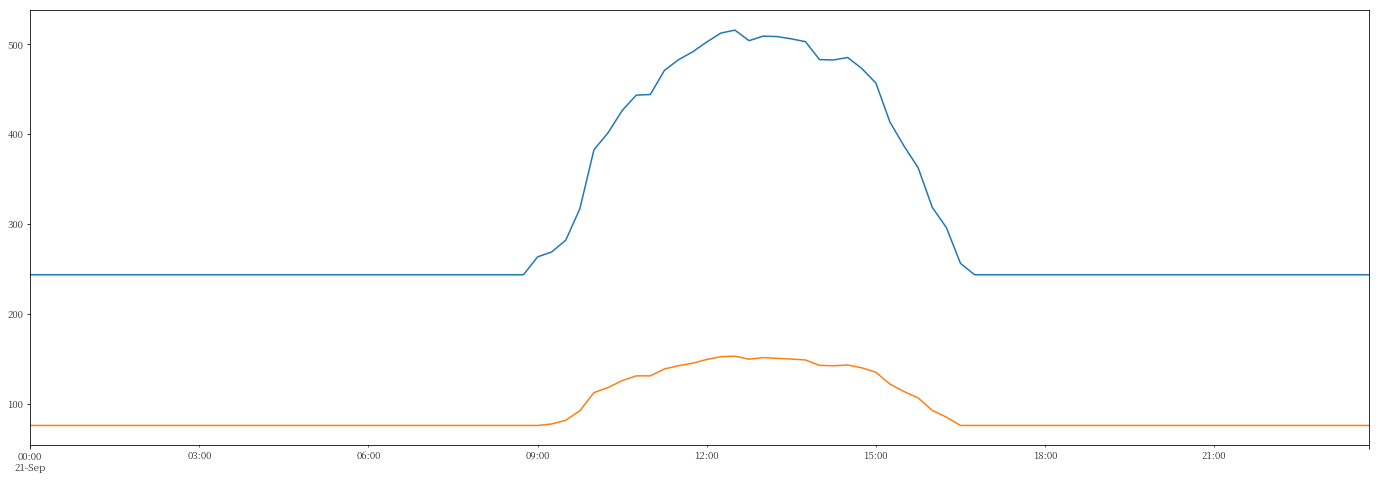

In [48]:
oid_ls = ['15481140757200897', '15481140757135361']
df_pred_new = post_pro_hand(oid_list=oid_ls, max_value_ls=[516, 153], df_pred=df_pred)
df_pred_new.loc[df_pred_new['oid']=='15481140757200897', 'y_pred'].plot(figsize=(24, 8))
df_pred_new.loc[df_pred_new['oid']=='15481140757135361', 'y_pred'].plot(figsize=(24, 8))

100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


In [84]:
df['loc'] = df[['jd', 'wd']].apply(tuple, axis=1)
df_ls_shift = []
df_ls = []
for loc, value in df.groupby('loc'):
    df_ls_shift.append(value['pjfs2fz'].shift(96).rename('{}_lag{}'.format('pjfs2fz', i)))
    df_ls.append(value['pjfs2fz'])
        

In [62]:
import glob
import catboost as cb
model_path = 'test_his/center_jiutian/2023-09-09'
df_ls = []
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']
oid_list = sorted(oid_list)
for idx, model_file in enumerate(glob.glob(os.path.join(model_path, 'windmodel*'))):
    model = cb.CatBoostRegressor()
    model.load_model(model_file)
    feau_impo = model.get_feature_importance()
    feau_name = model.feature_names_
    df_ = pd.DataFrame({'name_{}'.format(oid_list[idx]):feau_name, 'impo':feau_impo})
    df_ = df_.sort_values('impo', ascending=False)
    df_.reset_index(drop=True, inplace=True)
    df_ls.append(df_)
#     break
df = pd.concat(df_ls, axis=1)
df.to_csv('analyzise/test/model_impo.csv')

In [60]:
df.head(10)

,name_15481125255184390,impo,name_15481128891252742,impo,name_15481128900034564,impo,name_15481129194225670,impo,name_15481130476634115,impo,...,name_15481140766375937,impo,name_15481140766441473,impo,name_15481140766507009,impo,name_15481140766572545,impo,name_15481140830863361,impo
0,total_radiation_109.133_21.45,10.583707,total_radiation_105.483_25.117,8.439780,num_samples,30.965680,num_samples,14.205440,num_samples,4.253446,...,ten_meter_wind_speed_109.05_19.27,18.651289,hour_cos,8.937942,one_hundred_wind_speed_110.75_19.62,3.252812,total_radiation_110.25_20.0,30.303014,one_hundred_wind_speed_109.17_18.75,2.838711
1,total_radiation_109.55_22.267,7.823607,total_radiation_105.183_25.433,6.904878,one_hundred_wind_speed_106.764_25.429,3.941405,one_hundred_wind_speed_110.5_24.767,13.071004,one_hundred_wind_speed_109.133_21.45,4.013631,...,num_samples,9.308633,total_radiation_109.133_21.45,7.115655,one_hundred_wind_speed_105.289_27.298,2.558793,total_radiation_110.165_20.243,7.054348,one_hundred_wind_speed_109.52_18.77,2.301075
2,total_radiation_110.165_20.243,5.745096,total_radiation_104.528_25.751,6.781126,one_hundred_wind_speed_106.728_26.59,1.049780,one_hundred_wind_speed_110.633_24.65,4.058730,ten_meter_wind_speed_109.133_21.45,3.814712,...,one_hundred_wind_speed_109.05_19.27,7.815877,total_radiation_109.57_18.22,6.815650,ten_meter_wind_speed_112.773_21.736,1.901992,hour_cos,5.122003,ten_meter_wind_speed_109.43_19.23,1.970848
3,hour_cos,3.269503,total_radiation_103.328_23.444,3.493403,ten_meter_wind_direction_110.33_18.8,0.950658,one_hundred_wind_speed_109.7_23.983,1.523282,one_hundred_wind_speed_109.183_21.667,2.459389,...,ten_meter_wind_speed_109.43_19.23,2.093161,total_radiation_110.165_20.243,6.146331,ten_meter_wind_speed_105.289_27.298,1.291332,total_radiation_110.3_25.317,3.884050,ten_meter_wind_speed_109.52_18.77,1.927767
4,total_radiation_110.25_20.0,3.092824,total_radiation_106.083_25.183,3.479089,one_hundred_meter_wind_direction_115.276_24.114,0.876240,one_hundred_wind_speed_109.667_23.6,1.517809,one_hundred_wind_speed_112.773_21.736,2.168869,...,ten_meter_wind_speed_109.52_18.77,1.627071,total_radiation_108.667_26.967,5.239117,ten_meter_wind_speed_110.33_18.8,0.913333,total_radiation_109.55_22.267,3.570909,one_hundred_wind_speed_109.1_21.033,1.813326
5,total_radiation_109.57_18.22,2.722120,total_radiation_109.57_18.22,3.416876,hour_cos,0.856625,one_hundred_wind_speed_107.55_24.983,1.441040,ten_meter_wind_speed_112.773_21.736,2.011010,...,one_hundred_wind_speed_109.17_18.75,1.429656,total_radiation_109.58_19.52,4.362018,ten_meter_wind_direction_113.009_23.145,0.872767,total_radiation_111.978_21.845,3.248211,ten_meter_wind_speed_109.1_21.033,1.732648
6,total_radiation_110.068_20.962,2.302434,total_radiation_101.663_26.038,2.977194,one_hundred_meter_wind_direction_107.95_21.567,0.830159,one_hundred_wind_speed_109.1_21.033,1.319058,one_hundred_wind_speed_107.95_21.567,1.997250,...,ten_meter_wind_direction_100.965_22.787,1.221016,total_radiation_110.25_20.0,4.097770,one_hundred_wind_speed_112.773_21.736,0.855594,total_radiation_109.58_19.52,2.557497,ten_meter_wind_direction_112.475_22.991,1.560336
7,total_radiation_111.787_22.164,2.175834,total_radiation_102.653_25.008,2.559422,one_hundred_wind_speed_114.927_24.448,0.801077,one_hundred_wind_speed_109.4_25.233,1.196997,ten_meter_wind_speed_107.95_21.567,1.901200,...,one_hundred_wind_speed_110.33_18.8,1.046469,total_radiation_111.787_22.164,3.198825,one_hundred_meter_wind_direction_109.52_18.77,0.848819,total_radiation_109.57_18.22,2.258169,ten_meter_wind_speed_109.17_18.75,1.560296
8,total_radiation_110.3_25.317,1.639890,num_samples,2.508551,total_radiation_100.177_25.708,0.796974,one_hundred_wind_speed_107.88_25.41,1.157096,ten_meter_wind_direction_110.989_21.546,1.733862,...,ten_meter_wind_speed_109.83_19.03,0.773089,total_radiation_109.55_22.267,2.555365,ten_meter_wind_direction_106.233_27.467,0.827644,total_radiation_111.787_22.164,1.102868,one_hundred_wind_speed_1

In [2]:
import glob
import catboost as cb
model_path = 'test_his/center_jiutian/2023-09-27'
df_ls = []
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']
oid_list = sorted(oid_list)
for oid in oid_list:
    model = cb.CatBoostRegressor()
    model.load_model(model_path+oid)
    feau_impo = model.get_feature_importance()
    feau_name = model.feature_names_
    df_ = pd.DataFrame({'name_{}'.format(oid):feau_name, 'impo':feau_impo})
    df_ = df_.sort_values('impo', ascending=False)
    df_.reset_index(drop=True, inplace=True)
    df_ls.append(df_)
#     break
df = pd.concat(df_ls, axis=1)
df.to_csv('analyzise/test/model_impo1.csv')

In [4]:
df.head()

,name_15481125255184390,impo,name_15481128891252742,impo,name_15481128900034564,impo,name_15481129194225670,impo,name_15481130476634115,impo,...,name_15481140766375937,impo,name_15481140766441473,impo,name_15481140766507009,impo,name_15481140766572545,impo,name_15481140830863361,impo
0,num_samples,8.715323,num_samples,10.753118,num_samples,19.807376,one_hundred_wind_speed_110.98166666666665_24.9...,9.330772,one_hundred_wind_speed_114.20034467514046_22.1...,3.430637,...,num_samples,7.734863,num_samples,5.761392,num_samples,7.807285,num_samples,12.055546,num_samples,7.136501
1,total_radiation_110.51768388074885_21.40020794...,2.218202,total_radiation_105.03916666666666_26.70027777...,4.733715,one_hundred_wind_speed_105.6093096045233_26.54...,6.793025,one_hundred_wind_speed_110.98166666666665_24.9...,5.188581,ten_meter_wind_direction_113.19970549750839_24...,3.252961,...,ten_meter_wind_speed_109.09779444444445_19.633...,6.253968,total_radiation_110.02908124999999_19.93001249...,4.164858,one_hundred_wind_speed_108.3849_18.4925_cub,1.057807,total_radiation_110.92605087719299_19.72175146...,5.231707,one_hundred_meter_wind_direction_111.523997777...,3.272475
2,total_radiation_110.92605087719299_19.72175146...,2.094033,total_radiation_107.12160226592789_25.49100120...,3.258335,hour_cos,5.620042,hour_cos,5.009983,one_hundred_wind_speed_114.20034467514046_22.1...,3.242813,...,ten_meter_wind_speed_109.09779444444445_19.633...,3.685298,total_radiation_110.92605087719299_19.72175146...,3.551385,one_hundred_meter_wind_direction_108.616666666...,1.037803,time_96,3.078802,one_hundred_meter_wind_direction_114.200344675...,2.953834
3,total_radiation_110.02908124999999_19.93001249...,1.932280,total_radiation_110.92605087719299_19.72175146...,3.174233,one_hundred_wind_speed_105.6093096045233_26.54...,4.328413,ten_meter_wind_speed_110.43337210223969_25.246...,4.309010,num_samples,3.147810,...,one_hundred_wind_speed_109.09779444444445_19.6...,3.522572,total_radiation_110.22114814814815_19.65550370...,3.248238,one_hundred_meter_wind_direction_108.3849_18.4925,1.029320,hour_sin,2.941368,one_hundred_meter_wind_direction_108.3849_18.4925,2.421539
4,total_radiation_108.97561136914081_23.02124609...,1.864194,total_radiation_105.5015050347196_26.155979379...,2.896077,ten_meter_wind_direction_100.131625_26.0833333...,2.903269,one_hundred_wind_speed_110.98166666666665_24.9...,3.866369,ten_meter_wind_speed_116.54965262904254_23.261...,2.762160,...,one_hundred_wind_speed_109.09779444444445_19.6...,2.356307,total_radiation_109.58221048800662_19.67278795...,3.222766,ten_meter_wind_direction_110.71666666666667_21...,0.973671,total_radiation_110.92605087719299_19.72175146...,2.527837,one_hundred_wind_speed_112.39832708337073_21.4...,1.931419


In [7]:
df_ = pd.read_pickle('test_his/center_jiutian_v1/2023-09-13/df_radi_align.p')

In [8]:
df_.columns

Index(['total_radiation_112.17277778_21.86152778',
       'total_radiation_105.33296202_25.54534214',
       'total_radiation_108.97561137_23.02124609',
       'total_radiation_107.3115517_25.70025571',
       'total_radiation_104.1151098_27.03315639',
       'total_radiation_108.01967665_23.36920491',
       'total_radiation_107.15725883_23.79042896',
       'total_radiation_110.071735_20.50337897',
       'total_radiation_108.98458472_23.27013899',
       'total_radiation_108.45_22.5',
       'total_radiation_108.51164934_22.2077458',
       'total_radiation_109.338961_24.70005353',
       'total_radiation_108.28841454_22.42751476',
       'total_radiation_108.18319727_21.99522893',
       'total_radiation_108.48770111_21.89724204',
       'total_radiation_109.75940198_23.06730766',
       'total_radiation_105.44961732_26.8292439',
       'total_radiation_105.19633738_26.17116918',
       'total_radiation_110.51768388_21.40020795',
       'total_radiation_108.8398241_18.66888701',
  

In [90]:
pd.concat(df_ls, axis=1).head()

,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,...,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz
zlsc,,,,,,,,,,,,,,,,,,,,,
2023-08-01 00:00:00+08:00,1.7,1.5,0.7,0.4,1.0,0.0,0.6,0.6,0.7,0.8,...,1.2,1.6,1.4,1.8,1.1,1.2,0.6,1.7,1.6,1.3
2023-08-01 00:15:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 00:30:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 00:45:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 01:00:00+08:00,1.0,0.8,0.5,0.7,1.0,1.0,0.3,0.0,0.1,0.8,...,1.4,1.3,1.0,2.2,0.9,1.1,0.8,1.6,1.4,1.2
